In [2]:
### Cleaning up data ###
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('data/AirQualityUCI.csv', sep=';')

# Create timestamps
df.insert(0, 'Timestamp', pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H.%M.%S'))

# Drop useless columns
df = df.drop(['Unnamed: 15', 'Unnamed: 16', 'Date', 'Time'], axis=1)

# Columns to floats
for col in df.columns.drop('Timestamp'):
    df[col] = df[col].map(lambda x: float(str(x).replace(',', '.')))
    
# Add NaNs instead of 200
df = df.replace(-200, np.nan)

# Remove useless columns at end
df = df.loc[~pd.isnull(df['Timestamp']), :]

# Nice alternative dataframe with timestamps as index
df_ts = df.set_index('Timestamp', drop=True)

df.to_excel('output_data/cleaned.xlsx')

In [ ]:
import itertools

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler 
from collections import deque
from sklearn.metrics import root_mean_squared_error

# Impute missing ground truth data. This is purely an evaluation tool.

def get_train_test_validation(df_ts, *, target=None, validation=True):
    output_cols = ['CO(GT)', 'NMHC(GT)', 'NOx(GT)', 'NO2(GT)', 'C6H6(GT)']
    df_ts_input = df_ts.drop(output_cols, axis=1)
    df_ts_output = df_ts[output_cols]
    if target != None:
        df_ts_output = df_ts_output[[target]] 

    if not validation:
        df_train_X = df_ts_input[df_ts.index < '2005-01-01']
        df_test_X = df_ts_input[df_ts.index >= '2005-01-01']

        df_train_y = df_ts_output[df_ts.index < '2005-01-01']
        df_test_y = df_ts_output[df_ts.index >= '2005-01-01']
        
        return df_train_X, df_train_y, df_test_X, df_test_y 
    else:
        df_train_X = df_ts_input[df_ts.index < '2004-11-01']
        df_val_X = df_ts_input[(df_ts.index >= '2004-11-01') & (df_ts.index < '2005-01-01')]
        df_test_X = df_ts_input[df_ts.index >= '2005-01-01']

        df_train_y = df_ts_output[df_ts.index < '2004-11-01']
        df_val_y = df_ts_output[(df_ts.index >= '2004-11-01') & (df_ts.index < '2005-01-01')]
        df_test_y = df_ts_output[df_ts.index >= '2005-01-01']
        
        return df_train_X, df_train_y, df_test_X, df_test_y, df_val_X, df_val_y 
        

target = 'CO(GT)'
#df_train_X, df_train_y, df_test_X, df_test_y = get_train_test_validation(df_ts, target=target, validation=False)
df_train_X, df_train_y, df_test_X, df_test_y, df_val_X, df_val_y = get_train_test_validation(df_ts, target=target, validation=True)


class OnlineLinearModel:
    def __init__(self, hours_ahead_prediction, hyperparams, model_hyperparams):
        self.model = None
        self.shift = hours_ahead_prediction
        self.win_size = 50 
        self.scaler = None
        self.hyperparams = hyperparams
        self.model_hyperparams = model_hyperparams
        
    def feature_transform(self, train_X : pd.DataFrame, is_live):
        train_X = train_X.copy()

        # interpolation
        if is_live:
            train_X.ffill(inplace=True) 
        else:
            train_X.interpolate(method='time', inplace=True) # plot this
        train_X.dropna(inplace=True) # drop any columns which were NaN right at the start and could not be ffilled

        # normalisation
        train_X = pd.DataFrame(self.scaler.transform(train_X), columns=train_X.columns, index=train_X.index)

        # if is_live:
        #     window = train_X.head(self.win_size)
        #     max_seen = window.max(axis=0)
        #     min_seen = window.min(axis=0)
        #     for i in range(len(train_X)):
        #         max_seen = max_seen.combine(train_X.iloc[i], np.maximum)
        #         min_seen = min_seen.combine(train_X.iloc[i], np.minimum)
        #         train_X.iloc[i] = (train_X.iloc[i] - min_seen) / (max_seen - min_seen)
        # else:
        #     scaler = MinMaxScaler(copy=True)
        #     train_X = pd.DataFrame(scaler.fit_transform(train_X), columns=train_X.columns, index=train_X.index)
        

        # derived weekday, hour features
        # train_X['hour'] = train_X.index.hour
        # train_X['weekday'] = train_X.index.weekday
        # train_X['month'] = train_X.index.month
        
        # cyclic encoding
        def cycle_encode(series, max):
            angles = series * (2*np.pi/max)
            return np.sin(angles), np.cos(angles)
        train_X['hour_sin'], train_X['hour_cos'] = cycle_encode(train_X.index.hour, 24)
        train_X['weekday_sin'], train_X['weekday_cos'] = cycle_encode(train_X.index.weekday, 7)
        train_X['month_sin'], train_X['month_cos'] = cycle_encode(train_X.index.month, 12)
        train_X['is_weekend'] = train_X.index.weekday >= 5
        train_X['is_rush_hour'] = ((train_X.index.hour >= 6) & (train_X.index.hour <= 10)) | ((train_X.index.hour >= 18) & (train_X.index.hour <= 22)) 
        
        

        # collapse to window. Keep timestamp of the latest item in the window
        final_X = self._window_to_row(train_X.head(self.win_size))
        for i in range(self.win_size + 1, len(train_X)-1):
            final_X = pd.concat([final_X, self._window_to_row(train_X.iloc[i-self.win_size+1:i])])
        train_X = final_X
        
        return train_X
    
    def _window_to_row(self, window : pd.DataFrame):
        """
        Takes a window and outputs a row of data for prediction of shift
        Assumes window is normalised
        """ 
        
        lags = self.hyperparams['direct_lag_window']
        new_cols = [f'{col} lag_{i}'for i in range(lags) for col in window.columns ]
        df = pd.DataFrame([window.tail(lags).to_numpy().flat], columns=new_cols, index=window.tail(1).index)
        
        def lagged_sample(hours_back, nsamples):
            return window.tail(hours_back + (nsamples//2)).head(nsamples).mean()

        lagged_12h = lagged_sample(12, 4) 
        lagged_24h = lagged_sample(24, 6) 

        df['temp_avg_12h'] = lagged_12h['T']
        df['ah_avg_12h'] = lagged_12h['AH']
        df['rh_avg_12h'] = lagged_12h['RH']
        
        df['co_24h'] = lagged_24h['PT08.S1(CO)']
        df['co_12h'] = lagged_12h['PT08.S1(CO)']
        df['nox_12h'] = lagged_12h['PT08.S3(NOx)']
        df['no2_12h'] = lagged_12h['PT08.S4(NO2)']

        
        return df
    
    def train(self, train_X, train_y):
        self.scaler = MinMaxScaler().fit(train_X)
        train_X = self.feature_transform(train_X, False)
        
        train_y = train_y.interpolate(method='time')
        
        prediction_idx = train_X.index + pd.Timedelta(hours=self.shift)
        train_X = train_X[prediction_idx.isin(train_y.index)]
        train_y = train_y[train_y.index.isin(prediction_idx)]
        

        self.model = Ridge(**self.model_hyperparams).fit(train_X.to_numpy(), train_y.to_numpy()) 
        return self
    
    def predict(self, test_X):
        test_X = self.feature_transform(test_X, True)
        prediction_idx = test_X.index + pd.Timedelta(hours=self.shift)
        return pd.Series(self.model.predict(test_X.to_numpy()).flat, index=prediction_idx)


def equivalise(raw_true, raw_predictions):
    predictions = raw_predictions[raw_predictions.index.isin(raw_true.index)]
    true = raw_true[raw_true.index.isin(predictions.index)]
    return true, predictions
    
def grid_search(lag, train_X, train_y, val_X, val_y, hyperparams : dict, model_hyperparams : dict):
    """
    Runs a grid search. The train_y and val_y should NOT be shifted by the desired hours ahead to predict - the model does
    this automatically
    """
    hkeys, hvals = zip(*hyperparams.items())
    mhkeys, mhvals = zip(*model_hyperparams.items())
    hcombos = [x for x in itertools.product(*hvals)]
    mhcombos = [x for x in itertools.product(*mhvals)]

    best_rmse = float('inf')
    best_vals = None
    best_model = None
    
    for i, hcombo in enumerate(hcombos):
        for j, mhcombo in enumerate(mhcombos):
            hyperparams = {key: val for key, val in zip(hkeys, hcombo)}
            model_hyperparams = {key: val for key, val in zip(mhkeys, mhcombo)}
            model = OnlineLinearModel(lag, hyperparams=hyperparams, model_hyperparams=model_hyperparams).train(df_train_X, df_train_y)
            
            # evaluate
            true, predicted = equivalise(val_y, model.predict(val_X))
            rmse = root_mean_squared_error(true.to_numpy(), predicted.to_numpy()) 
            print(f'Evaluated hyperparameters {hyperparams} and model hyperparameters {model_hyperparams}. RMSE: {rmse}')
            if rmse < best_rmse:
                best_rmse = rmse 
                best_vals = (hyperparams, model_hyperparams)
                best_model = model
    
    return best_model, best_vals
    
    
lag = 1 
df_test_y_nona = df_test_y.dropna()[target]
df_val_y_nona = df_val_y.dropna()[target]

#model = OnlineLinearModel(lag).train(df_train_X, df_train_y)


# perhaps sensors lag true values in some way?
hyperparams = {
    'direct_lag_window': [3, 5, 8, 10, 15, 24, 48],
}
model_hyperparams = {
    'alpha': [0.3, 0.5, 1, 2, 5, 8]
}
model, vals = grid_search(lag, df_train_X, df_train_y, df_val_X, df_val_y_nona, hyperparams, model_hyperparams)

df_predict_y = model.predict(df_test_X)
naive_predictions = df_test_y.shift(lag).dropna()[target]

Evaluated hyperparameters {'direct_lag_window': 5} and model hyperparameters {'alpha': 0.5}. RMSE: 1.144310505100959
Evaluated hyperparameters {'direct_lag_window': 5} and model hyperparameters {'alpha': 1}. RMSE: 1.146741511748635
Evaluated hyperparameters {'direct_lag_window': 5} and model hyperparameters {'alpha': 2}. RMSE: 1.14978107807686
Evaluated hyperparameters {'direct_lag_window': 5} and model hyperparameters {'alpha': 5}. RMSE: 1.154653973736367
Evaluated hyperparameters {'direct_lag_window': 5} and model hyperparameters {'alpha': 8}. RMSE: 1.1579398018532145
Evaluated hyperparameters {'direct_lag_window': 8} and model hyperparameters {'alpha': 0.5}. RMSE: 1.1518452174695992
Evaluated hyperparameters {'direct_lag_window': 8} and model hyperparameters {'alpha': 1}. RMSE: 1.1550650214476343
Evaluated hyperparameters {'direct_lag_window': 8} and model hyperparameters {'alpha': 2}. RMSE: 1.1587294127203311
Evaluated hyperparameters {'direct_lag_window': 8} and model hyperparamet

#### Progress

- Model refuses to go below 0.97 RMSE even with grid search
- From residuals seems that it responds to spikes with too great a delay. Somehow incorporate momentum
- Willtry more features

In [143]:
### Ridge Version 2 ##


import itertools
import holidays
import multiprocessing
from scipy.stats import norm, linregress
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler 
from collections import deque
from sklearn.metrics import root_mean_squared_error

# Impute missing ground truth data. This is purely an evaluation tool.

def get_train_test_validation(df_ts, *, target=None, validation=True):
    output_cols = ['CO(GT)', 'NMHC(GT)', 'NOx(GT)', 'NO2(GT)', 'C6H6(GT)']
    df_ts_input = df_ts.drop(output_cols, axis=1)
    df_ts_output = df_ts[output_cols]
    if target != None:
        df_ts_output = df_ts_output[[target]] 

    if not validation:
        df_train_X = df_ts_input[df_ts.index < '2005-01-01']
        df_test_X = df_ts_input[df_ts.index >= '2005-01-01']

        df_train_y = df_ts_output[df_ts.index < '2005-01-01']
        df_test_y = df_ts_output[df_ts.index >= '2005-01-01']
        
        return df_train_X, df_train_y, df_test_X, df_test_y 
    else:
        df_train_X = df_ts_input[df_ts.index < '2004-11-01']
        df_val_X = df_ts_input[(df_ts.index >= '2004-11-01') & (df_ts.index < '2005-01-01')]
        df_test_X = df_ts_input[df_ts.index >= '2005-01-01']

        df_train_y = df_ts_output[df_ts.index < '2004-11-01']
        df_val_y = df_ts_output[(df_ts.index >= '2004-11-01') & (df_ts.index < '2005-01-01')]
        df_test_y = df_ts_output[df_ts.index >= '2005-01-01']
        
        return df_train_X, df_train_y, df_test_X, df_test_y, df_val_X, df_val_y 
        

target = 'CO(GT)'
#df_train_X, df_train_y, df_test_X, df_test_y = get_train_test_validation(df_ts, target=target, validation=False)
df_train_X, df_train_y, df_test_X, df_test_y, df_val_X, df_val_y = get_train_test_validation(df_ts, target=target, validation=True)


class OnlineLinearModel:
    def __init__(self, hours_ahead_prediction, hyperparams, model_hyperparams):
        self.model = None
        self.shift = hours_ahead_prediction
        self.win_size = 50 
        self.scaler = None
        self.hyperparams = hyperparams
        self.model_hyperparams = model_hyperparams
        
    def feature_transform(self, train_X : pd.DataFrame, is_live):
        train_X = train_X.copy()

        # interpolation
        if is_live:
            train_X.ffill(inplace=True) 
        else:
            train_X.interpolate(method='time', inplace=True) 
        train_X.dropna(inplace=True) # drop any columns which were NaN right at the start and could not be ffilled

        # initial normalisation
        train_X = pd.DataFrame(self.scaler.transform(train_X), columns=train_X.columns, index=train_X.index)
        
        # temporal feature encoding
        train_X = self._derive_temporal_features(train_X)

        # collapse to window. Keep timestamp of the latest item in the window
        final_X = self._window_to_row(train_X.head(self.win_size))
        for i in range(self.win_size + 1, len(train_X)-1):
            final_X = pd.concat([final_X, self._window_to_row(train_X.iloc[i-self.win_size+1:i])])
        train_X = final_X
        
        return train_X
    
    def _derive_temporal_features(self, train_X):
        # be careful to ensure that these are manually made normalised

        train_X = train_X.copy()

        # cyclic encoding
        def cycle_encode(series, max):
            angles = series * (2*np.pi/max)
            return np.sin(angles), np.cos(angles)

        train_X['hour_sin_24h'], train_X['hour_cos_24h'] = cycle_encode(train_X.index.hour, 24)
        train_X['hour_sin_12h'], train_X['hour_cos_12h'] = cycle_encode(train_X.index.hour % 12, 12) # 12h enhances separability for half-day cycle patterns
        train_X['weekday_sin'], train_X['weekday_cos'] = cycle_encode(train_X.index.weekday, 7)
        train_X['month_sin'], train_X['month_cos'] = cycle_encode(train_X.index.month, 12)
        
        # special markers
        train_X['is_weekend'] = train_X.index.weekday >= 5
        train_X['is_rush_hour'] = ((train_X.index.hour >= 6) & (train_X.index.hour <= 10)) | ((train_X.index.hour >= 18) & (train_X.index.hour <= 22)) 

        def days_from_public_hol(date):
            public_holidays = pd.Series(pd.Timestamp(x) for x in holidays.country_holidays('IT', years=[2004, 2005]).keys())
            x = public_holidays - pd.Series([date] * len(public_holidays))
            return x.abs().min().days
        def effect_of_public_hol(date, effect_scale=5):
            # use norm to get a bell shape, normalise it to 1
            return norm.pdf(days_from_public_hol(date), loc=0, scale=effect_scale) / norm.pdf(0, loc=0, scale=effect_scale)

        #days_from_hol = train_X.index.map(lambda x : days_from_public_hol(x))
        #train_X['days_from_public_hol'] = days_from_hol / days_from_hol.max()
        train_X['effect_of_public_hol'] = train_X.index.map(lambda x : effect_of_public_hol(x))

        return train_X
    
    def _window_to_row(self, window : pd.DataFrame):
        """
        Takes a window and outputs a row of data for prediction of shift
        Assumes window is normalised
        """ 
        
        # raw lags of most recent features
        lags = self.hyperparams['direct_lag_window']
        new_cols = [f'{col} lag_{i}'for i in range(lags) for col in window.columns ]
        df = pd.DataFrame([window.tail(lags).to_numpy().flat], columns=new_cols, index=window.tail(1).index)

        # lagged averages        
        def lagged_sample(hours_back, nsamples):
            return window.tail(hours_back + (nsamples//2)).head(nsamples).mean()            
        lagged_12h = lagged_sample(12, 4) 
        lagged_24h = lagged_sample(24, 6) 

        df['temp_avg_12h'] = lagged_12h['T']
        df['ah_avg_12h'] = lagged_12h['AH']
        df['rh_avg_12h'] = lagged_12h['RH']
        
        df['co_24h'] = lagged_24h['PT08.S1(CO)']
        df['co_12h'] = lagged_12h['PT08.S1(CO)']
        df['nox_12h'] = lagged_12h['PT08.S3(NOx)']
        df['no2_12h'] = lagged_12h['PT08.S4(NO2)']
        

        # ratios: ratio between NOx and NO2 reveals
        # freshness of traffic emissions.
        # def compress_01(x):
        #     # compresses a positive value into the 0-1 range with a long tail
        #     return 1. - np.exp(-np.max([0., x]))
        # nox_no2_ratio =  window['PT08.S3(NOx)'].iloc[-1] / (window['PT08.S4(NO2)'].iloc[-1] + 1e-6)
        # nox_no2_ratio_lag12 = lagged_12h['PT08.S3(NOx)'] / (lagged_12h['PT08.S4(NO2)'] + 1e-6)
        # df['nox_no2_ratio'] = compress_01(nox_no2_ratio)
        # df['nox_no2_ratio_lag12'] = compress_01(nox_no2_ratio_lag12)
        
        # # volatility of readings
        # df['co_volatility'] = window['PT08.S1(CO)'].tail(8).std()
        # df['nox_volatility'] = window['PT08.S3(NOx)'].tail(8).std()
        # df['no2_volatility'] = window['PT08.S4(NO2)'].tail(8).std()
        # df['temp_volatility'] = window['T'].tail(8).std()
        # df['rh_volatility'] = window['RH'].tail(8).std()
        
        # # # meteorogical interaction effects
        # df['t_rh_interaction'] = lagged_12h['T'] * lagged_12h['RH'] # humidity-temperature synergies

        # # # capturing momentum via trends
        def get_trend(series):
            vals = series.values
            regression = linregress(range(len(vals)), vals)
            slope = regression.slope
            return slope
        
        df['co_trend_6h'] = get_trend(window['PT08.S1(CO)'].tail(6))
        df['co_trend_24h'] = get_trend(window['PT08.S1(CO)'].tail(24))
        # df['nox_trend_6h'] = get_trend(window['PT08.S3(NOx)'].tail(6))
        # df['no2_trend_6h'] = get_trend(window['PT08.S4(NO2)'].tail(6))
        
        return df
    
    def _y_transform(self, train_y):
        train_y = train_y.interpolate(method='time')
        series = pd.Series(np.log1p(train_y.to_numpy()).flat, index=train_y.index)
        return series

    def _y_inverse_transform(self, pred_y):
        return pd.Series(np.expm1(pred_y.to_numpy()).flat, index=pred_y.index)
    
    def train(self, train_X, train_y):
        self.scaler = MinMaxScaler().fit(train_X)
        train_X = self.feature_transform(train_X, False)

        train_y = self._y_transform(train_y) 
        
        prediction_idx = train_X.index + pd.Timedelta(hours=self.shift)
        train_X = train_X[prediction_idx.isin(train_y.index)]
        train_y = train_y[train_y.index.isin(prediction_idx)]
        

        self.model = Ridge(**self.model_hyperparams).fit(train_X.to_numpy(), train_y.to_numpy()) 
        return self
    
    def predict(self, test_X):
        test_X = self.feature_transform(test_X, True)
        prediction_idx = test_X.index + pd.Timedelta(hours=self.shift)
        predictions = pd.Series(self.model.predict(test_X.to_numpy()).flat, index=prediction_idx)
        return self._y_inverse_transform(predictions)


def equivalise(raw_true, raw_predictions):
    predictions = raw_predictions[raw_predictions.index.isin(raw_true.index)]
    true = raw_true[raw_true.index.isin(predictions.index)]
    return true, predictions
    
def grid_search(lag, train_X, train_y, val_X, val_y, hyperparams : dict, model_hyperparams : dict):
    """
    Runs a grid search. The train_y and val_y should NOT be shifted by the desired hours ahead to predict - the model does
    this automatically
    """
    hkeys, hvals = zip(*hyperparams.items())
    mhkeys, mhvals = zip(*model_hyperparams.items())
    hcombos = [x for x in itertools.product(*hvals)]
    mhcombos = [x for x in itertools.product(*mhvals)]

    best_rmse = float('inf')
    best_vals = None
    best_model = None
    
    global test_model # function must be global to run in a pool
    def test_model(hyperparams, model_hyperparams):
        model = OnlineLinearModel(lag, hyperparams=hyperparams, model_hyperparams=model_hyperparams).train(df_train_X, df_train_y)
        true, predicted = equivalise(val_y, model.predict(val_X))
        rmse = root_mean_squared_error(true.to_numpy(), predicted.to_numpy()) 
        return ((hyperparams, model_hyperparams), rmse)
        
    results = []
    with multiprocessing.Pool() as pool:
        for i, hcombo in enumerate(hcombos):
            for j, mhcombo in enumerate(mhcombos):
                hyperparams = {key: val for key, val in zip(hkeys, hcombo)}
                model_hyperparams = {key: val for key, val in zip(mhkeys, mhcombo)}
                results.append(pool.apply_async(test_model, [hyperparams, model_hyperparams]) )
    
        for r in results:
            (hyperparams, model_hyperparams), rmse = r.get()
            print(f'Evaluated hyperparameters {hyperparams} and model hyperparameters {model_hyperparams}. RMSE: {rmse}')
            if rmse < best_rmse:
                best_rmse = rmse 
                best_vals = (hyperparams, model_hyperparams)
                best_model = OnlineLinearModel(lag, hyperparams=hyperparams, model_hyperparams=model_hyperparams).train(df_train_X, df_train_y)
        
        return best_model, best_vals
    
    
lag = 1 
df_test_y_nona = df_test_y.dropna()[target]
df_val_y_nona = df_val_y.dropna()[target]

#model = OnlineLinearModel(lag).train(df_train_X, df_train_y)


# hyperparams = {
#     'direct_lag_window': [3, 7, 14, 26, 49],
# }
# model_hyperparams = {
#     'alpha': [0.05, 0.1, 0.2, 0.5, 1, 2, 5],
#     'l1_ratio': [0.02, 0.05, 0.1, 0.3, 0.7]
# }
hyperparams = {
    'direct_lag_window': [12]#, 14],
}
model_hyperparams = {
    #'fit_intercept': [True]
    'alpha': [100, 200, 400],#, 0.1, 1],
    # 'l1_ratio': [0.001]#, 0.02, 0.1]
}
model, vals = grid_search(lag, df_train_X, df_train_y, df_val_X, df_val_y_nona, hyperparams, model_hyperparams)

df_predict_y = model.predict(df_test_X)
naive_predictions = df_test_y.shift(lag).dropna()[target]

Evaluated hyperparameters {'direct_lag_window': 12} and model hyperparameters {'alpha': 100}. RMSE: 1.0956334035858823
Evaluated hyperparameters {'direct_lag_window': 12} and model hyperparameters {'alpha': 200}. RMSE: 1.1058816749370477
Evaluated hyperparameters {'direct_lag_window': 12} and model hyperparameters {'alpha': 400}. RMSE: 1.1377744504407183


({'direct_lag_window': 6}, {'alpha': 10})


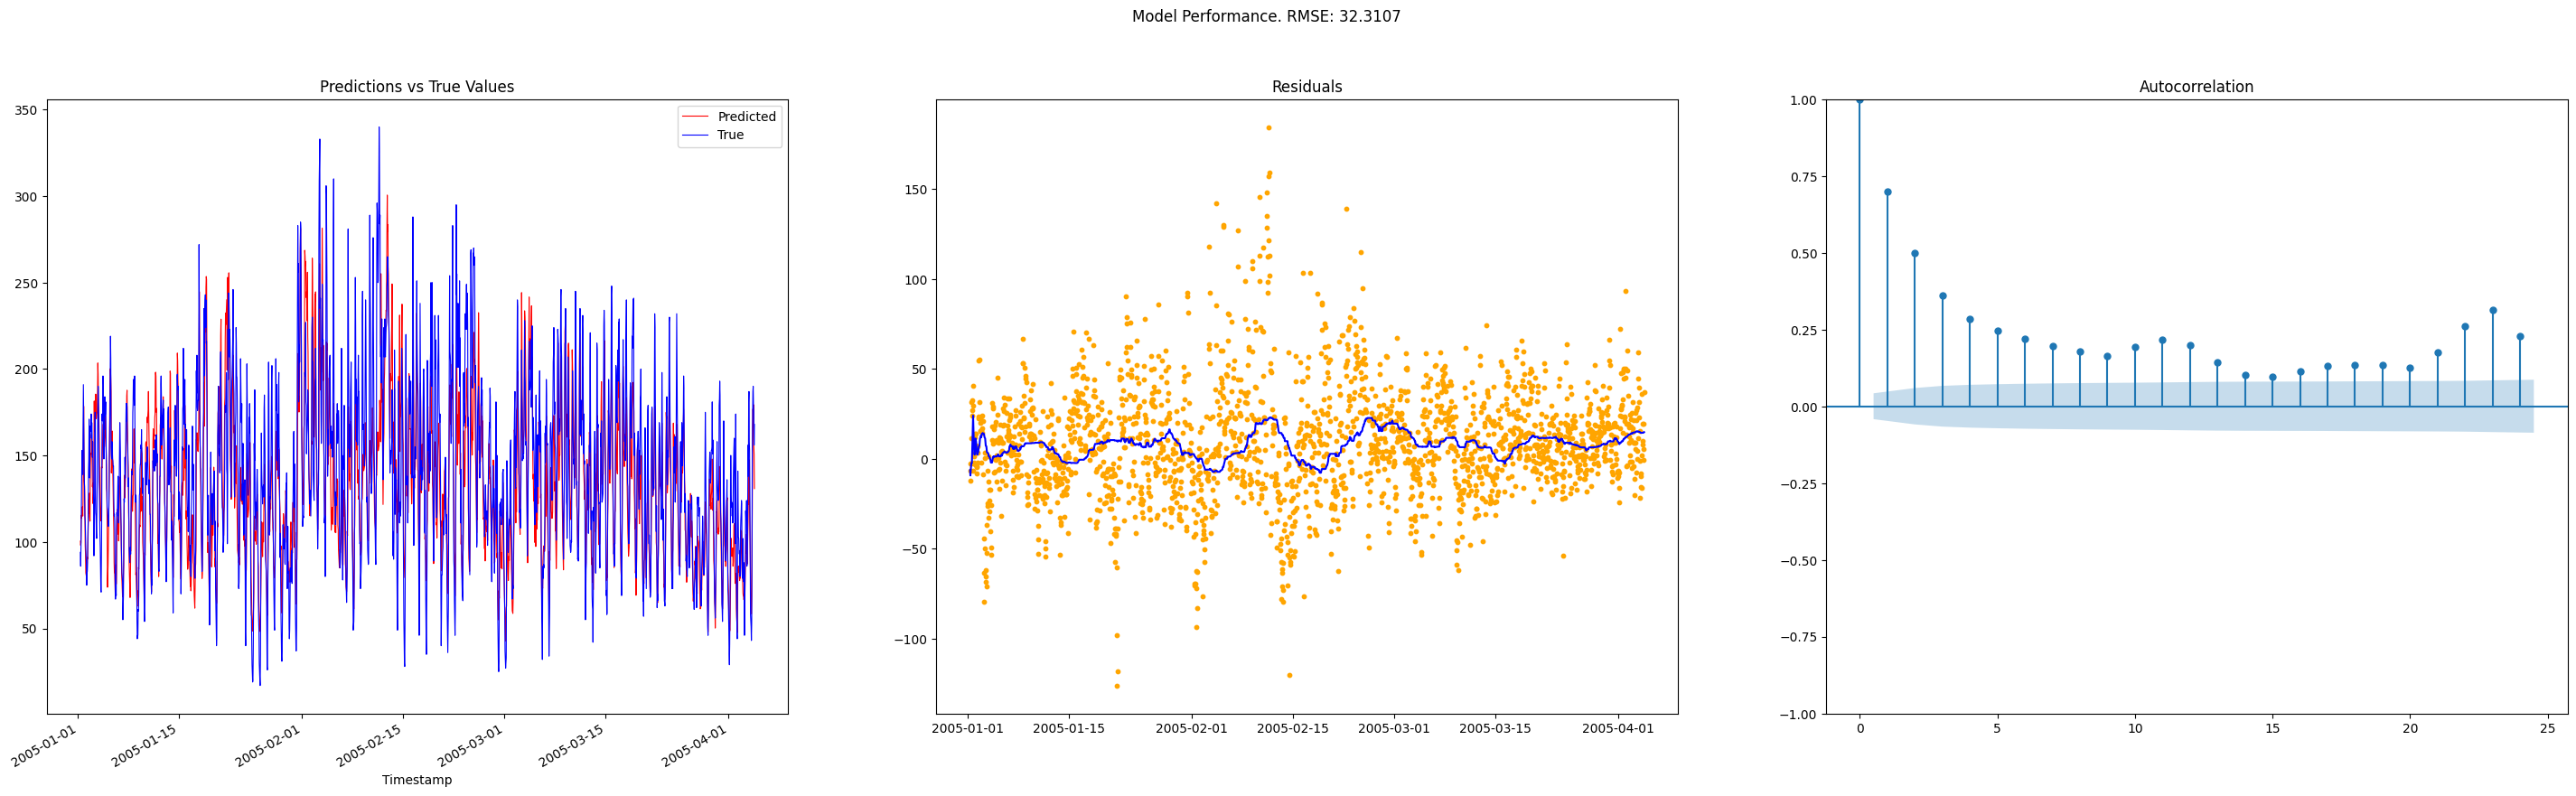

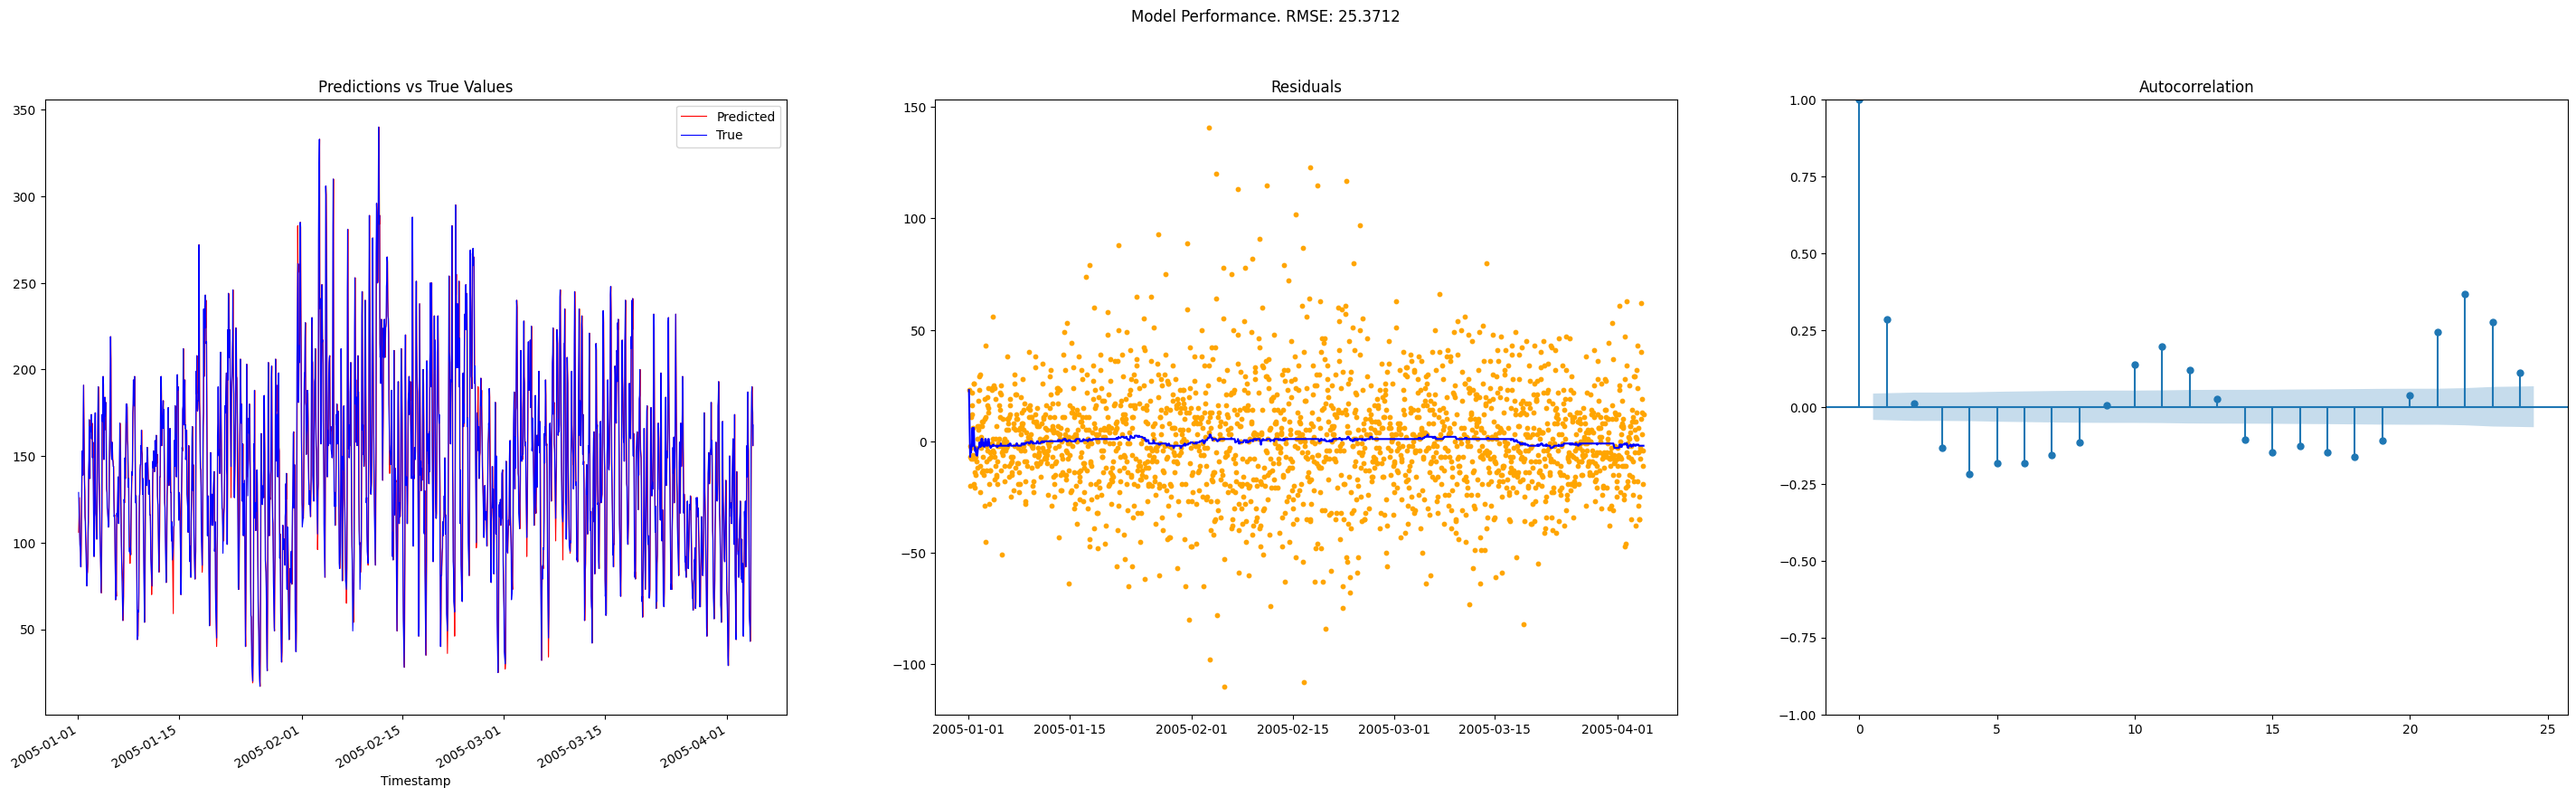

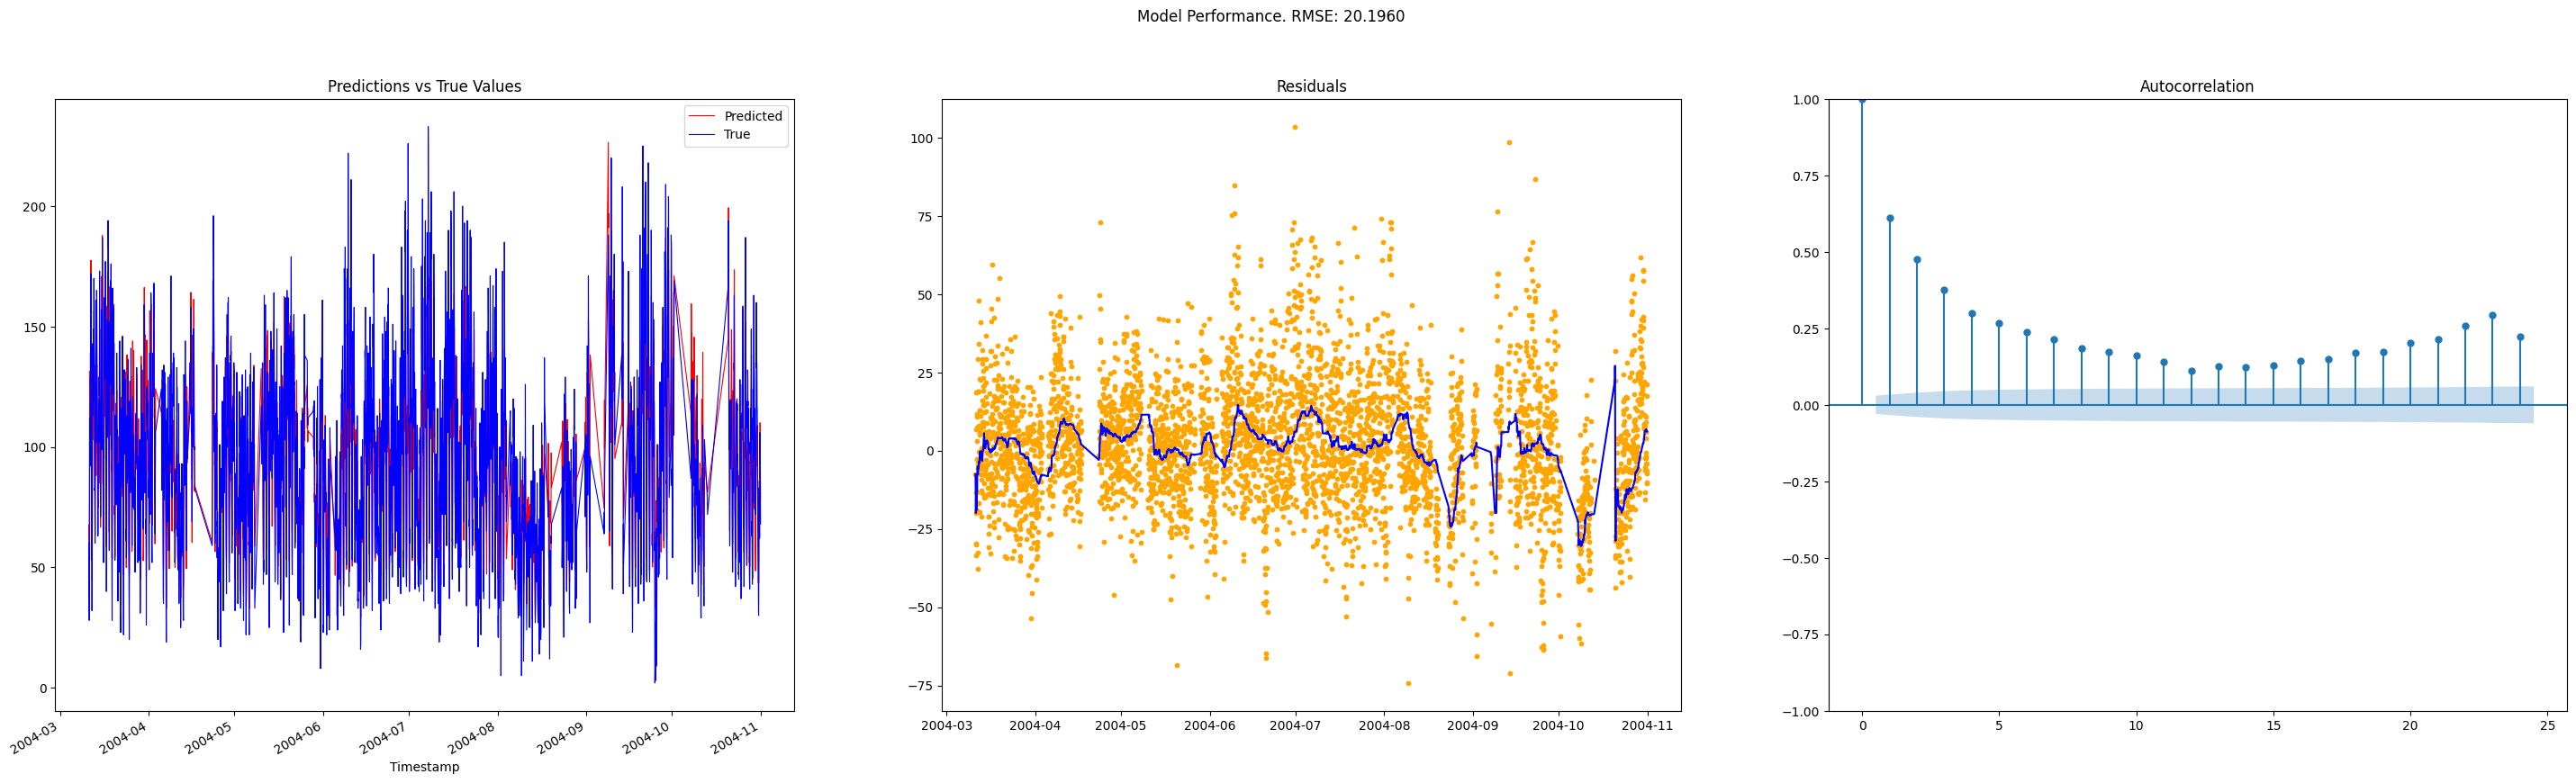

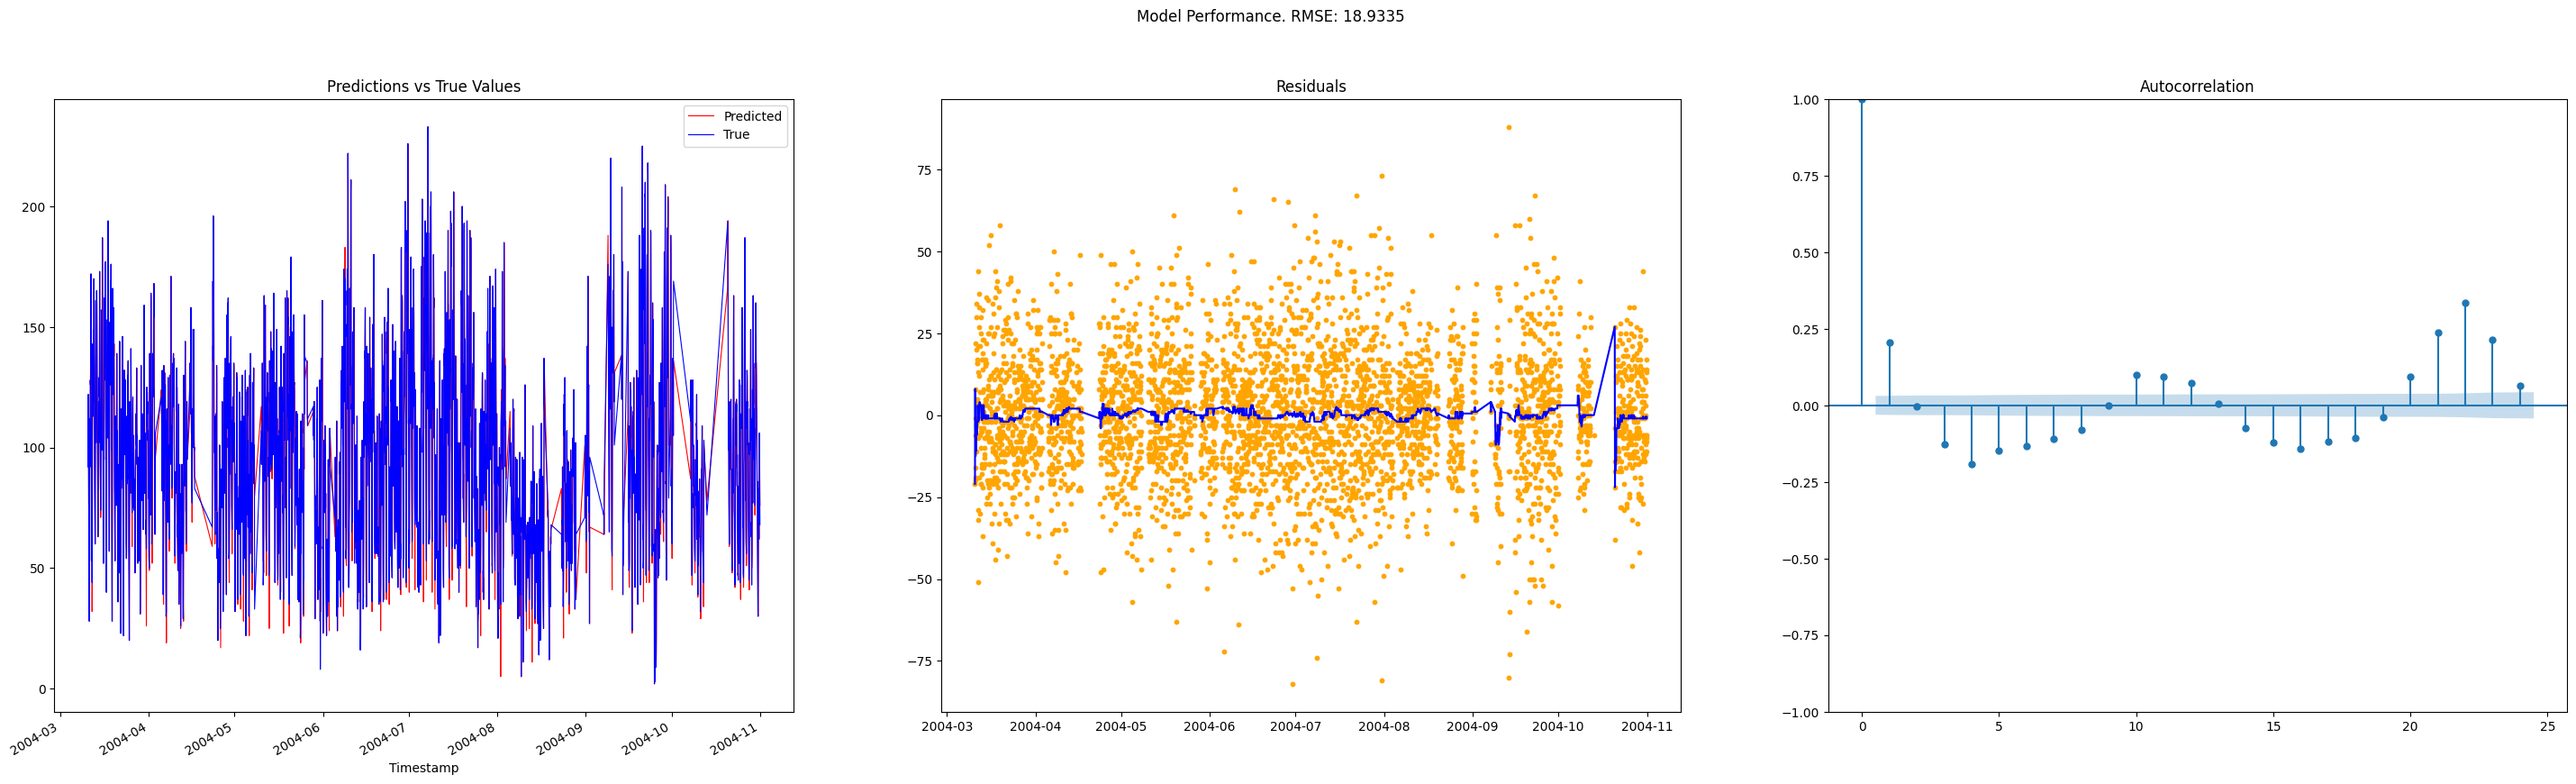

In [101]:
from statsmodels.graphics.tsaplots import plot_acf 

def evaluate(true, predictions):
    # normalise indices
    true, predictions = equivalise(true, predictions)
    
    # plot
    fig, ax = plt.subplots(1, 3, figsize=(36, 10))
    
    predictions.rename('Predicted')
    true.rename('True')

    line_pred = predictions.plot(linewidth=0.8, color='red', ax=ax[0], label='Predicted')
    line_true = true.plot(linewidth=0.8, color='blue', ax=ax[0], label='True')
    ax[0].set_title('Predictions vs True Values')
    ax[0].legend()
    
    residuals = true - predictions
    ax[1].scatter(residuals.index, residuals.values, s=10, color='orange')
    ax[1].set_title('Residuals')
    
    roll = residuals.rolling('168h').median()
    ax[1].plot(roll.index, roll.values, color='blue')
    
    rmse = root_mean_squared_error(true.to_numpy(), predictions.to_numpy())
    
    # acf of residuals measures correlation between two residuals - spike at lag 1
    # means that model has undercaptured short term momentum.
    # ideally residuals should just be in the form of noise, so no autocorellation. Low ACF means model extracted all forecastable signal
    plot_acf(residuals, ax=ax[2], lags=24)
    
    fig.suptitle(f'Model Performance. RMSE: {rmse:.4f}')
    
print(vals)
evaluate(df_test_y_nona, df_predict_y)
evaluate(df_test_y_nona, naive_predictions)

evaluate(df_train_y.dropna()[target], df_train_predict_y)
evaluate(df_train_y.dropna()[target], naive_train_predictions)

#### Progress
- After adding log scaling it seems much more powerful regularisation is required since can overestimate significantly. However by looking at graph it looks like pattern of predictions matches better.

The ridge regression now has optimal hyperparameter alpha=100, suggesting that the exponential scaling of the output variable makes the model prone to large swings. The autocorrelation at lag 1 is high at around 0.7. It seems that the model does not respond quickly enough to changes in the data: if a spike occurs it predicts a spike shortly afterwards when it has already dropped back down.

In [90]:
### Ridge Version 3: simpler and with less memory to allow spikes ###

import itertools
import holidays
import multiprocessing
from scipy.stats import norm, linregress
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler 
from collections import deque
from sklearn.metrics import root_mean_squared_error

# Impute missing ground truth data. This is purely an evaluation tool.

def get_train_test_validation(df_ts, *, target=None, validation=True):
    output_cols = ['CO(GT)', 'NMHC(GT)', 'NOx(GT)', 'NO2(GT)', 'C6H6(GT)']
    df_ts_input = df_ts.drop(output_cols, axis=1)
    df_ts_output = df_ts[output_cols]
    if target != None:
        df_ts_output = df_ts_output[[target]] 

    if not validation:
        df_train_X = df_ts_input[df_ts.index < '2005-01-01']
        df_test_X = df_ts_input[df_ts.index >= '2005-01-01']

        df_train_y = df_ts_output[df_ts.index < '2005-01-01']
        df_test_y = df_ts_output[df_ts.index >= '2005-01-01']
        
        return df_train_X, df_train_y, df_test_X, df_test_y 
    else:
        df_train_X = df_ts_input[df_ts.index < '2004-11-01']
        df_val_X = df_ts_input[(df_ts.index >= '2004-11-01') & (df_ts.index < '2005-01-01')]
        df_test_X = df_ts_input[df_ts.index >= '2005-01-01']

        df_train_y = df_ts_output[df_ts.index < '2004-11-01']
        df_val_y = df_ts_output[(df_ts.index >= '2004-11-01') & (df_ts.index < '2005-01-01')]
        df_test_y = df_ts_output[df_ts.index >= '2005-01-01']
        
        return df_train_X, df_train_y, df_test_X, df_test_y, df_val_X, df_val_y 
        

target = 'NO2(GT)'
#df_train_X, df_train_y, df_test_X, df_test_y = get_train_test_validation(df_ts, target=target, validation=False)
df_train_X, df_train_y, df_test_X, df_test_y, df_val_X, df_val_y = get_train_test_validation(df_ts, target=target, validation=True)


class OnlineLinearModel:
    def __init__(self, hours_ahead_prediction, hyperparams, model_hyperparams):
        self.model = None
        self.shift = hours_ahead_prediction
        self.win_size = 50 
        self.scaler = None
        self.hyperparams = hyperparams
        self.model_hyperparams = model_hyperparams
        
    def _feature_transform(self, train_X : pd.DataFrame, is_live):
        train_X = train_X.copy()

        # interpolation
        if is_live:
            train_X.ffill(inplace=True) 
        else:
            train_X.interpolate(method='time', inplace=True) 
        train_X.dropna(inplace=True) # drop any columns which were NaN right at the start and could not be ffilled
        
        # temporal feature encoding
        train_X = self._derive_temporal_features(train_X)

        # collapse to window. Keep timestamp of the latest item in the window
        final_X = self._window_to_row(train_X.head(self.win_size))
        for i in range(self.win_size + 1, len(train_X)):
            final_X = pd.concat([final_X, self._window_to_row(train_X.iloc[i-self.win_size:i])])
        train_X = final_X
        
        return train_X

    def _normalise(self, X, is_train):
        if is_train:
            self.scaler = MinMaxScaler().fit(X)
        return pd.DataFrame(self.scaler.transform(X), columns=X.columns, index=X.index) 
    
    def _derive_temporal_features(self, train_X):
        train_X = train_X.copy()

        # cyclic encoding
        def cycle_encode(series, max):
            angles = series * (2*np.pi/max)
            return np.sin(angles), np.cos(angles)

        train_X['hour_sin_24h'], train_X['hour_cos_24h'] = cycle_encode(train_X.index.hour, 24)
        train_X['weekday_sin'], train_X['weekday_cos'] = cycle_encode(train_X.index.weekday, 7)
        train_X['month_sin'], train_X['month_cos'] = cycle_encode(train_X.index.month, 12)
        
        # special markers
        train_X['is_weekend'] = train_X.index.weekday >= 5
        train_X['is_rush_hour'] = ((train_X.index.hour >= 6) & (train_X.index.hour <= 10)) | ((train_X.index.hour >= 18) & (train_X.index.hour <= 22)) 

        def days_from_public_hol(date):
            public_holidays = pd.Series(pd.Timestamp(x) for x in holidays.country_holidays('IT', years=[2004, 2005]).keys())
            x = public_holidays - pd.Series([date] * len(public_holidays))
            return x.abs().min().days
        def effect_of_public_hol(date, effect_scale=5):
            # use norm to get a bell shape, normalise it to 1
            return norm.pdf(days_from_public_hol(date), loc=0, scale=effect_scale) / norm.pdf(0, loc=0, scale=effect_scale)

        days_from_hol = train_X.index.map(lambda x : days_from_public_hol(x))
        train_X['days_from_public_hol'] = days_from_hol / days_from_hol.max()
        train_X['effect_of_public_hol'] = train_X.index.map(lambda x : effect_of_public_hol(x))
         
        return train_X
    
    def _window_to_row(self, window : pd.DataFrame):
        """
        Takes a window and outputs a row of data for prediction of shift
        Assumes window is normalised
        """ 
        
        # raw lags of most recent features
        lags = self.hyperparams['direct_lag_window']
        new_cols = [f'{col} lag_{i}'for i in range(lags) for col in window.columns ]
        df = pd.DataFrame([window.tail(lags).to_numpy().flat], columns=new_cols, index=window.tail(1).index)

        # lagged averages        
        def lagged_sample(hours_back, nsamples):
            return window.tail(hours_back + (nsamples//2)).head(nsamples).mean()            
        lagged_12h = lagged_sample(12, 4) 
        lagged_24h = lagged_sample(24, 6) 

        df['temp_avg_12h'] = lagged_12h['T']
        df['ah_avg_12h'] = lagged_12h['AH']
        df['rh_avg_12h'] = lagged_12h['RH']
        
        df['co_24h'] = lagged_24h['PT08.S1(CO)']
        df['co_12h'] = lagged_12h['PT08.S1(CO)']
        df['nox_12h'] = lagged_12h['PT08.S3(NOx)']
        df['no2_12h'] = lagged_12h['PT08.S4(NO2)']
        

        # ratios: ratio between NOx and NO2 reveals
        # freshness of traffic emissions.
        def compress_01(x):
            # compresses a positive value into the 0-1 range with a long tail
            return 1. - np.exp(-np.max([0., x]))
        nox_no2_ratio =  window['PT08.S3(NOx)'].iloc[-1] / (window['PT08.S4(NO2)'].iloc[-1] + 1e-6)
        nox_no2_ratio_lag12 = lagged_12h['PT08.S3(NOx)'] / (lagged_12h['PT08.S4(NO2)'] + 1e-6)
        df['nox_no2_ratio'] = compress_01(nox_no2_ratio)
        df['nox_no2_ratio_lag12'] = compress_01(nox_no2_ratio_lag12)
        
        # # volatility of readings
        df['co_volatility'] = window['PT08.S1(CO)'].tail(8).std()
        df['nox_volatility'] = window['PT08.S3(NOx)'].tail(8).std()
        df['no2_volatility'] = window['PT08.S4(NO2)'].tail(8).std()
        df['temp_volatility'] = window['T'].tail(8).std()
        df['rh_volatility'] = window['RH'].tail(8).std()
        
        # # # meteorogical interaction effects
        df['t_rh_interaction'] = lagged_12h['T'] * lagged_12h['RH'] # humidity-temperature synergies
        df['co_delta_1h'] = window['PT08.S1(CO)'].tail(2).diff().iloc[-1]
        df['nox_delta_3h'] = window['PT08.S3(NOx)'].tail(4).diff(3).iloc[-1]
        df['temp_delta_1h'] = window['T'].tail(2).diff().iloc[-1]

        # # # capturing momentum via trends
        def get_trend(series):
            vals = series.values
            regression = linregress(range(len(vals)), vals)
            slope = regression.slope
            return slope
        
        df['co_trend_6h'] = get_trend(window['PT08.S1(CO)'].tail(6))
        df['co_trend_24h'] = get_trend(window['PT08.S1(CO)'].tail(24))
        
        ar_weights = [0.7, 0.2, 0.1]
        df['co_proxy'] = sum(w * window['PT08.S1(CO)'].iloc[-(i+1)] for i, w in enumerate(ar_weights))
        df['nox_trend_6h'] = get_trend(window['PT08.S3(NOx)'].tail(6))
        df['no2_trend_6h'] = get_trend(window['PT08.S4(NO2)'].tail(6))
        
        return df
    
    def _y_transform(self, train_y):
        train_y = train_y.interpolate(method='time')
        series = pd.Series(np.log1p(train_y.to_numpy()).flat, index=train_y.index)
        return series

    def _y_inverse_transform(self, pred_y):
        return pd.Series(np.expm1(pred_y.to_numpy()).flat, index=pred_y.index)
    
    def train(self, train_X, train_y, transform = False):
        train_X = self._normalise(self._feature_transform(train_X, False) if transform else train_X, is_train=True)
        train_y = self._y_transform(train_y) 
        
        train_X.index = train_X.index + pd.Timedelta(hours=self.shift)
        train_X, train_y = equivalise(train_X, train_y)

        self.model = Ridge(**self.model_hyperparams).fit(train_X.to_numpy(), train_y.to_numpy()) 
        return self
    
    def predict(self, test_X, transform=False):
        test_X = self._normalise(self._feature_transform(test_X, True) if transform else test_X, is_train=False)
        prediction_idx = test_X.index + pd.Timedelta(hours=self.shift)
        predictions = pd.Series(self.model.predict(test_X.to_numpy()).flat, index=prediction_idx)
        return self._y_inverse_transform(predictions)

    def transform(self, X, is_test):
        return self._feature_transform(X, is_live=is_test)


def equivalise(raw_true, raw_predictions):
    predictions = raw_predictions[raw_predictions.index.isin(raw_true.index)]
    true = raw_true[raw_true.index.isin(predictions.index)]
    return true, predictions
    
def grid_search(lag, train_X, train_y, val_X, val_y, hyperparams : dict, model_hyperparams : dict):
    """
    Runs a grid search. The train_y and val_y should NOT be shifted by the desired hours ahead to predict - the model does
    this automatically
    """
    hkeys, hvals = zip(*hyperparams.items())
    mhkeys, mhvals = zip(*model_hyperparams.items())
    hcombos = [x for x in itertools.product(*hvals)]
    mhcombos = [x for x in itertools.product(*mhvals)]

    best_rmse = float('inf')
    best_vals = None
    best_model = None
    
    global test_model # function must be global to run in a pool
    def test_model(hyperparams, model_hyperparams, train_X, train_y, val_X, val_y):
        model = OnlineLinearModel(lag, hyperparams=hyperparams, model_hyperparams=model_hyperparams).train(train_X, train_y, transform=False)
        true, predicted = equivalise(val_y, model.predict(val_X, transform=False))
        rmse = root_mean_squared_error(true.to_numpy(), predicted.to_numpy()) 
        return ((hyperparams, model_hyperparams), rmse)
        
    results = []
    with multiprocessing.Pool() as pool:
        for i, hcombo in enumerate(hcombos):
            hyperparams = {key: val for key, val in zip(hkeys, hcombo)}
            transformed_train = OnlineLinearModel(lag, hyperparams=hyperparams, model_hyperparams={}).transform(train_X, False)
            transformed_val = OnlineLinearModel(lag, hyperparams=hyperparams, model_hyperparams={}).transform(val_X, True)
            for j, mhcombo in enumerate(mhcombos):
                model_hyperparams = {key: val for key, val in zip(mhkeys, mhcombo)}
                results.append(pool.apply_async(test_model, [hyperparams, model_hyperparams, transformed_train, train_y, transformed_val, val_y]) )
    
        for r in results:
            (hyperparams, model_hyperparams), rmse = r.get()
            print(f'Evaluated hyperparameters {hyperparams} and model hyperparameters {model_hyperparams}. RMSE: {rmse}')
            if rmse < best_rmse:
                best_rmse = rmse 
                best_vals = (hyperparams, model_hyperparams)
                best_model = OnlineLinearModel(lag, hyperparams=hyperparams, model_hyperparams=model_hyperparams).train(train_X, train_y, transform=True)
        
        return best_model, best_vals
    
    
lag = 1 
df_test_y_nona = df_test_y.dropna()[target]
df_val_y_nona = df_val_y.dropna()[target]

#model = OnlineLinearModel(lag).train(df_train_X, df_train_y)

hyperparams = {
    'direct_lag_window': [6, 12],
}
model_hyperparams = {
    #'learning_rate': [0.05, 0.1, 0.2, 0.5]
    'alpha': [0.1, 0.2, 0.5, 0.8, 2, 5, 10]
}
model, vals = grid_search(lag, df_train_X, df_train_y, df_val_X, df_val_y_nona, hyperparams, model_hyperparams)

df_train_predict_y = model.predict(df_train_X, transform=True)
naive_train_predictions = df_train_y.shift(lag).dropna()[target]

df_predict_y = model.predict(df_test_X, transform=True)
naive_predictions = df_test_y.shift(lag).dropna()[target]

Evaluated hyperparameters {'direct_lag_window': 6} and model hyperparameters {'alpha': 0.1}. RMSE: 35.00396621682431
Evaluated hyperparameters {'direct_lag_window': 6} and model hyperparameters {'alpha': 0.2}. RMSE: 34.657046169845856
Evaluated hyperparameters {'direct_lag_window': 6} and model hyperparameters {'alpha': 0.5}. RMSE: 34.096915308810274
Evaluated hyperparameters {'direct_lag_window': 6} and model hyperparameters {'alpha': 0.8}. RMSE: 33.800100224321234
Evaluated hyperparameters {'direct_lag_window': 6} and model hyperparameters {'alpha': 2}. RMSE: 33.27465540119388
Evaluated hyperparameters {'direct_lag_window': 6} and model hyperparameters {'alpha': 5}. RMSE: 32.93632116784317
Evaluated hyperparameters {'direct_lag_window': 6} and model hyperparameters {'alpha': 10}. RMSE: 32.88104929939969
Evaluated hyperparameters {'direct_lag_window': 12} and model hyperparameters {'alpha': 0.1}. RMSE: 36.120890487656474
Evaluated hyperparameters {'direct_lag_window': 12} and model hy

In [ ]:
df_train_predict_y = model.predict(df_train_X, transform=True)
naive_train_predictions = df_train_y.shift(lag).dropna()[target]

0.00014888407471772114
0.33035588340637156
0.12061615526566857


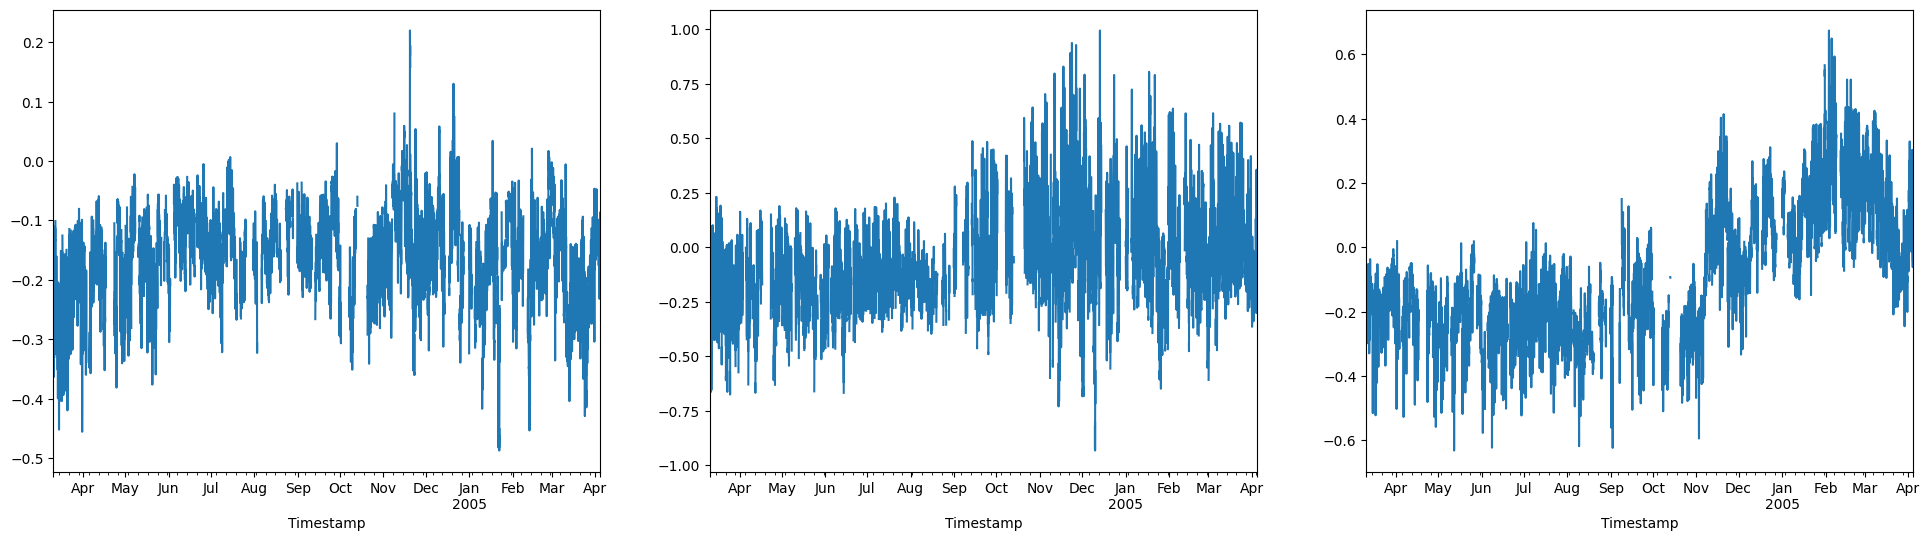

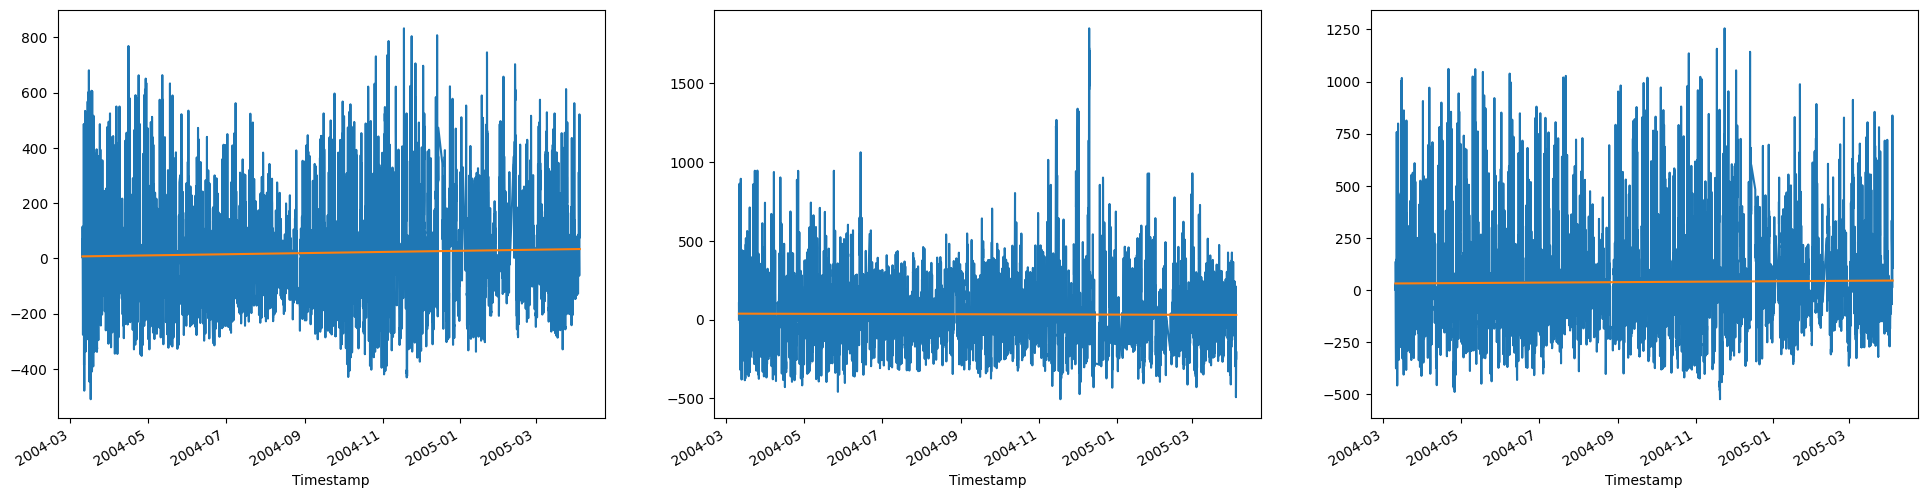

In [91]:

# Look at the sensor drift

def plot_sensor_drift(sensor, gt, ax):
    df_tester = df_ts[[sensor, gt]]
    df_tester_scaled = pd.DataFrame(MinMaxScaler().fit_transform(df_tester), columns=df_tester.columns, index = df_tester.index)
    df_tester_scaled['diff'] = (df_tester_scaled[gt] - df_tester_scaled[sensor])
    df_tester_scaled['diff'].plot(ax=ax)
    
fig,ax = plt.subplots(1, 3, figsize=(24,6))
plot_sensor_drift('PT08.S1(CO)', 'CO(GT)', ax[0])
plot_sensor_drift('PT08.S3(NOx)', 'NOx(GT)', ax[1])
plot_sensor_drift('PT08.S4(NO2)', 'NO2(GT)', ax[2])


def plot_drift_residuals(sensor, ax):
    roll = df_ts[sensor].rolling(pd.Timedelta('168h'), center=True).median()
    residual = (df_ts[sensor] - roll).dropna()
    residual.plot(ax=ax)
    reg = linregress(range(len(residual)), residual)
    print(reg.pvalue)
    ax.plot([residual.index[0], residual.index[-1]], [reg.intercept, reg.intercept + reg.slope * len(residual)])

fig,ax = plt.subplots(1, 3, figsize=(24,6))
plot_drift_residuals('PT08.S1(CO)', ax[0])
plot_drift_residuals('PT08.S3(NOx)', ax[1])
plot_drift_residuals('PT08.S4(NO2)', ax[2])

In [61]:
# diagnostic of seasonality

def diag_shift(df, period, var):
    sub = df[df.index.year == 2004 if period=='train' else df.index.year == 2005]
    return {'mean': sub[var].mean(), 'var': sub[var].var(), 
            'nan_pct': sub[var].isna().mean(), 'acf_lag1': sub[var].autocorr(lag=1)}

print('Train (2004):', diag_shift(df_ts, 'train', 'CO(GT)'))
print('Test (2005):', diag_shift(df_ts, 'test', 'CO(GT)'))

print('Train (2004):', diag_shift(df_ts, 'train', 'NO2(GT)'))
print('Test (2005):', diag_shift(df_ts, 'test', 'NO2(GT)'))

print('Train (2004):', diag_shift(df_ts, 'train', 'NOx(GT)'))
print('Test (2005):', diag_shift(df_ts, 'test', 'NOx(GT)'))

Train (2004): {'mean': np.float64(2.1905718422005065), 'var': np.float64(2.2042097362857276), 'nan_pct': np.float64(0.22278481012658227), 'acf_lag1': np.float64(0.8392355554886192)}
Test (2005): {'mean': np.float64(2.0554469273743017), 'var': np.float64(1.8623317517232045), 'nan_pct': np.float64(0.044058744993324434), 'acf_lag1': np.float64(0.8292371478636026)}
Train (2004): {'mean': np.float64(101.69384809669855), 'var': np.float64(1768.5589065716522), 'nan_pct': np.float64(0.22039381153305204), 'acf_lag1': np.float64(0.8874366830253678)}
Test (2005): {'mean': np.float64(142.17771639042357), 'var': np.float64(2620.5616773253323), 'nan_pct': np.float64(0.03337783711615487), 'acf_lag1': np.float64(0.8755176257720616)}
Train (2004): {'mean': np.float64(218.66949152542372), 'var': np.float64(42868.032674114715), 'nan_pct': np.float64(0.219971870604782), 'acf_lag1': np.float64(0.9141636290776372)}
Test (2005): {'mean': np.float64(318.97237569060775), 'var': np.float64(44513.406882792), 'na

In [123]:
## Attempt 4 - addressing sensor drift, temporal concept drift and seasonality
import itertools
import holidays
import multiprocessing
from scipy.stats import norm, linregress
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler 
from collections import deque
from sklearn.metrics import root_mean_squared_error

def get_train_test_validation(df_ts, *, target=None, validation=True):
    output_cols = ['CO(GT)', 'NMHC(GT)', 'NOx(GT)', 'NO2(GT)', 'C6H6(GT)']
    df_ts_input = df_ts.drop(output_cols, axis=1)
    df_ts_output = df_ts[output_cols]
    if target != None:
        df_ts_output = df_ts_output[[target]] 

    if not validation:
        df_train_X = df_ts_input[df_ts.index < '2005-01-01']
        df_test_X = df_ts_input[df_ts.index >= '2005-01-01']

        df_train_y = df_ts_output[df_ts.index < '2005-01-01']
        df_test_y = df_ts_output[df_ts.index >= '2005-01-01']
        
        return df_train_X, df_train_y, df_test_X, df_test_y 
    else:
        df_train_X = df_ts_input[df_ts.index < '2004-11-01']
        df_val_X = df_ts_input[(df_ts.index >= '2004-11-01') & (df_ts.index < '2005-01-01')]
        df_test_X = df_ts_input[df_ts.index >= '2005-01-01']

        df_train_y = df_ts_output[df_ts.index < '2004-11-01']
        df_val_y = df_ts_output[(df_ts.index >= '2004-11-01') & (df_ts.index < '2005-01-01')]
        df_test_y = df_ts_output[df_ts.index >= '2005-01-01']
        
        return df_train_X, df_train_y, df_test_X, df_test_y, df_val_X, df_val_y 
        
class OnlineLinearModel:
    def __init__(self, hours_ahead_prediction, hyperparams, model_hyperparams):
        self.model = None
        self.shift = hours_ahead_prediction
        self.win_size = 25 
        self.scaler = None
        self.hyperparams = hyperparams
        self.model_hyperparams = model_hyperparams
        self.detrend_coefs = None
        
    def _feature_transform(self, train_X : pd.DataFrame, is_live):
        train_X = train_X.copy()

        # interpolation
        if is_live:
            train_X.ffill(inplace=True) 
        else:
            train_X.interpolate(method='time', inplace=True) 
        train_X.dropna(inplace=True) # drop any columns which were NaN right at the start and could not be ffilled
        
        # calculate trends
        # sensors = ['PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)','PT08.S5(O3)']
        # def calc_trend_x():
        #     return (train_X.index - df_ts.index[0]) / pd.Timedelta(hours=1)
        # if not is_live:
        #     self.detrend_coefs = {}
        #     for s in sensors:
        #         self.detrend_coefs[s] = np.polyfit(calc_trend_x(), train_X[s], deg=2)
        # for s in sensors:
        #     train_X[f'{s}_global_detrend'] = train_X[s] - np.polyval(self.detrend_coefs[s], calc_trend_x())
         
        # temporal feature encoding
        train_X = self._derive_temporal_features(train_X)
        
        # non-window features
        train_X = self._derive_concurrent_features(train_X)

        # collapse to window. Keep timestamp of the latest item in the window
        lags = pd.concat([train_X.shift(i).add_suffix(f'_lag{i}') for i in range(1, self.hyperparams['direct_lag_window'] + 1)], axis=1)
        train_X = pd.concat([train_X, lags], axis=1).dropna()
        
        return train_X

    def _normalise(self, X, is_train):
        if is_train:
            self.scaler = MinMaxScaler().fit(X)
        return pd.DataFrame(self.scaler.transform(X), columns=X.columns, index=X.index) 
    
    def _derive_temporal_features(self, train_X):
        train_X = train_X.copy()

        # cyclic encoding
        def cycle_encode(series, max):
            angles = series * (2*np.pi/max)
            return np.sin(angles), np.cos(angles)

        train_X['hour_sin_24h'], train_X['hour_cos_24h'] = cycle_encode(train_X.index.hour, 24)
        train_X['weekday_sin'], train_X['weekday_cos'] = cycle_encode(train_X.index.weekday, 7)
        train_X['month_sin'], train_X['month_cos'] = cycle_encode(train_X.index.month, 12)
        
        # special markers
        train_X['is_weekend'] = train_X.index.weekday >= 5
        train_X['is_rush_hour'] = ((train_X.index.hour >= 6) & (train_X.index.hour <= 10)) | ((train_X.index.hour >= 18) & (train_X.index.hour <= 22)) 

        def days_from_public_hol(date):
            public_holidays = pd.Series(pd.Timestamp(x) for x in holidays.country_holidays('IT', years=[2004, 2005]).keys())
            x = public_holidays - pd.Series([date] * len(public_holidays))
            return x.abs().min().days
        def effect_of_public_hol(date, effect_scale=5):
            # use norm to get a bell shape, normalise it to 1
            return norm.pdf(days_from_public_hol(date), loc=0, scale=effect_scale) / norm.pdf(0, loc=0, scale=effect_scale)

        days_from_hol = train_X.index.map(lambda x : days_from_public_hol(x))
        train_X['days_from_public_hol'] = days_from_hol / days_from_hol.max()
        train_X['effect_of_public_hol'] = train_X.index.map(lambda x : effect_of_public_hol(x))
         
        return train_X

    def _derive_concurrent_features(self, train_X):
        # calculate all the rolls you need
        rolled168 = train_X.rolling(pd.Timedelta('168h'))
        rolled24 = train_X.rolling(pd.Timedelta('24h'))
        rolled12 = train_X.rolling(pd.Timedelta('12h'))
        rolled6 = train_X.rolling(pd.Timedelta('6h'))

        lagged_24h = train_X.rolling(pd.Timedelta('8h'), center=True).mean().shift(24)
        lagged_12h = train_X.rolling(pd.Timedelta('8h'), center=True).mean().shift(12)
        
        train_X, _ = equivalise(train_X, rolled168.mean())

        sensors = ['PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)','PT08.S5(O3)']
        met = ['T', 'AH', 'RH']
        all = sensors + met

        for s in sensors:
            train_X[f'{s}_detrended'] = train_X[s] - rolled168[s].median()
            
            train_X[f'{s}_delta_1h'] = train_X[s] - train_X.shift(1, fill_value=0)[s]
            train_X[f'{s}_delta_3h'] = train_X[s] - train_X.shift(3, fill_value=0)[s]
            train_X[f'{s}_delta_6h'] = train_X[s] - train_X.shift(6, fill_value=0)[s]

        for s in all: 
            train_X[f'{s}_volatility'] = rolled12[s].std()
            train_X[f'{s}_avg_24h'] = lagged_24h[s]
            train_X[f'{s}_avg_12h'] = lagged_12h[s]

        # ratios: ratio between NOx and NO2 reveals freshness of traffic emissions.
        def compress_01(x):
            # compresses a positive value into the 0-1 range with a long tail
            return 1. - np.exp(-np.max([0., x]))
        train_X['nox_no2_ratio'] = (train_X['PT08.S3(NOx)'] / (train_X['PT08.S4(NO2)'] + 1e-6)).map(lambda x: compress_01(x))
        
        # meteorogical interaction effects
        train_X['t_rh_interaction'] = train_X['T'] * train_X['RH'] # humidity-temperature synergies
        
        # capturing momentum via trends
        def get_trend(series):
            return linregress(range(len(series)), series).slope
        for s in all:
            train_X[f'{s}_momentum_6h'] = rolled6[s].apply(get_trend, raw=True)
            train_X[f'{s}_momentum_24h'] = rolled24[s].apply(get_trend, raw=True)
        
        # counter sensor drift
        train_X['sensor_age_days'] = (train_X.index - df_ts.index[0]).days # note we use the original df_ts to get first measurement

        for col in sensors:
            x = np.arange(len(train_X)) 

        
        return train_X
    
    def _y_transform(self, train_y):
        train_y = train_y.interpolate(method='time')
        series = pd.Series(np.log1p(train_y.to_numpy()).flat, index=train_y.index)
        return series

    def _y_inverse_transform(self, pred_y):
        return pd.Series(np.expm1(pred_y.to_numpy()).flat, index=pred_y.index)
    
    def train(self, train_X, train_y, transform = False):
        train_X = self._normalise(self._feature_transform(train_X, False) if transform else train_X, is_train=True)
        train_y = self._y_transform(train_y) 
        
        train_X.index = train_X.index + pd.Timedelta(hours=self.shift)
        train_X, train_y = equivalise(train_X, train_y)

        self.model = Ridge(**self.model_hyperparams).fit(train_X.to_numpy(), train_y.to_numpy()) 
        return self
    
    def predict(self, test_X, transform=False):
        test_X = self._normalise(self._feature_transform(test_X, True) if transform else test_X, is_train=False)
        prediction_idx = test_X.index + pd.Timedelta(hours=self.shift)
        predictions = pd.Series(self.model.predict(test_X.to_numpy()).flat, index=prediction_idx)
        return self._y_inverse_transform(predictions)

    def transform(self, X, is_test):
        return self._feature_transform(X, is_live=is_test)

# helper functions
def equivalise(raw_true, raw_predictions):
    predictions = raw_predictions[raw_predictions.index.isin(raw_true.index)]
    true = raw_true[raw_true.index.isin(predictions.index)]
    return true, predictions
    
def grid_search(lag, train_X, train_y, val_X, val_y, hyperparams : dict, model_hyperparams : dict):
    """
    Runs a grid search. The train_y and val_y should NOT be shifted by the desired hours ahead to predict - the model does
    this automatically
    """
    hkeys, hvals = zip(*hyperparams.items())
    mhkeys, mhvals = zip(*model_hyperparams.items())
    hcombos = [x for x in itertools.product(*hvals)]
    mhcombos = [x for x in itertools.product(*mhvals)]

    best_rmse = float('inf')
    best_vals = None
    best_model = None
    
    global test_model # function must be global to run in a pool
    def test_model(hyperparams, model_hyperparams, train_X, train_y, val_X, val_y):
        model = OnlineLinearModel(lag, hyperparams=hyperparams, model_hyperparams=model_hyperparams).train(train_X, train_y, transform=False)
        true, predicted = equivalise(val_y, model.predict(val_X, transform=False))
        rmse = root_mean_squared_error(true.to_numpy(), predicted.to_numpy()) 
        return ((hyperparams, model_hyperparams), rmse)
        
    results = []
    with multiprocessing.Pool() as pool:
        for i, hcombo in enumerate(hcombos):
            hyperparams = {key: val for key, val in zip(hkeys, hcombo)}
            
            model = OnlineLinearModel(lag, hyperparams=hyperparams, model_hyperparams={})
            transformed_train = model.transform(train_X, False)
            transformed_val = model.transform(val_X, True)
            for j, mhcombo in enumerate(mhcombos):
                model_hyperparams = {key: val for key, val in zip(mhkeys, mhcombo)}
                results.append(pool.apply_async(test_model, [hyperparams, model_hyperparams, transformed_train, train_y, transformed_val, val_y]) )
    
        for r in results:
            (hyperparams, model_hyperparams), rmse = r.get()
            print(f'Evaluated hyperparameters {hyperparams} and model hyperparameters {model_hyperparams}. RMSE: {rmse}')
            if rmse < best_rmse:
                best_rmse = rmse 
                best_vals = (hyperparams, model_hyperparams)
                best_model = OnlineLinearModel(lag, hyperparams=hyperparams, model_hyperparams=model_hyperparams).train(train_X, train_y, transform=True)
        
        return best_model, best_vals
    

target = 'CO(GT)'
lag = 1 
df_train_X, df_train_y, df_test_X, df_test_y, df_val_X, df_val_y = get_train_test_validation(df_ts, target=target, validation=True)

hyperparams = {
    'direct_lag_window': [6, 12, 24, 96],
}
model_hyperparams = {
    #'learning_rate': [0.05, 0.1, 0.2, 0.5]
    'alpha': [0.1, 0.2, 0.5, 0.8, 2, 5, 10, 15, 20, 30, 50, 80, 100, 200, 500, 1000]
}
model, vals = grid_search(lag, df_train_X, df_train_y, df_val_X, df_val_y.dropna(), hyperparams, model_hyperparams)


Evaluated hyperparameters {'direct_lag_window': 6} and model hyperparameters {'alpha': 0.1}. RMSE: 2.2081890052313775
Evaluated hyperparameters {'direct_lag_window': 6} and model hyperparameters {'alpha': 0.2}. RMSE: 2.190476069757669
Evaluated hyperparameters {'direct_lag_window': 6} and model hyperparameters {'alpha': 0.5}. RMSE: 2.156197721668257
Evaluated hyperparameters {'direct_lag_window': 6} and model hyperparameters {'alpha': 0.8}. RMSE: 2.1324103917936004
Evaluated hyperparameters {'direct_lag_window': 6} and model hyperparameters {'alpha': 2}. RMSE: 2.071000327776073
Evaluated hyperparameters {'direct_lag_window': 6} and model hyperparameters {'alpha': 5}. RMSE: 1.985614870169208
Evaluated hyperparameters {'direct_lag_window': 6} and model hyperparameters {'alpha': 10}. RMSE: 1.8961315537945893
Evaluated hyperparameters {'direct_lag_window': 6} and model hyperparameters {'alpha': 15}. RMSE: 1.827860936090881
Evaluated hyperparameters {'direct_lag_window': 6} and model hyperp

Printing model evaluation. Model has hyperparameters ({'direct_lag_window': 6}, {'alpha': 500})


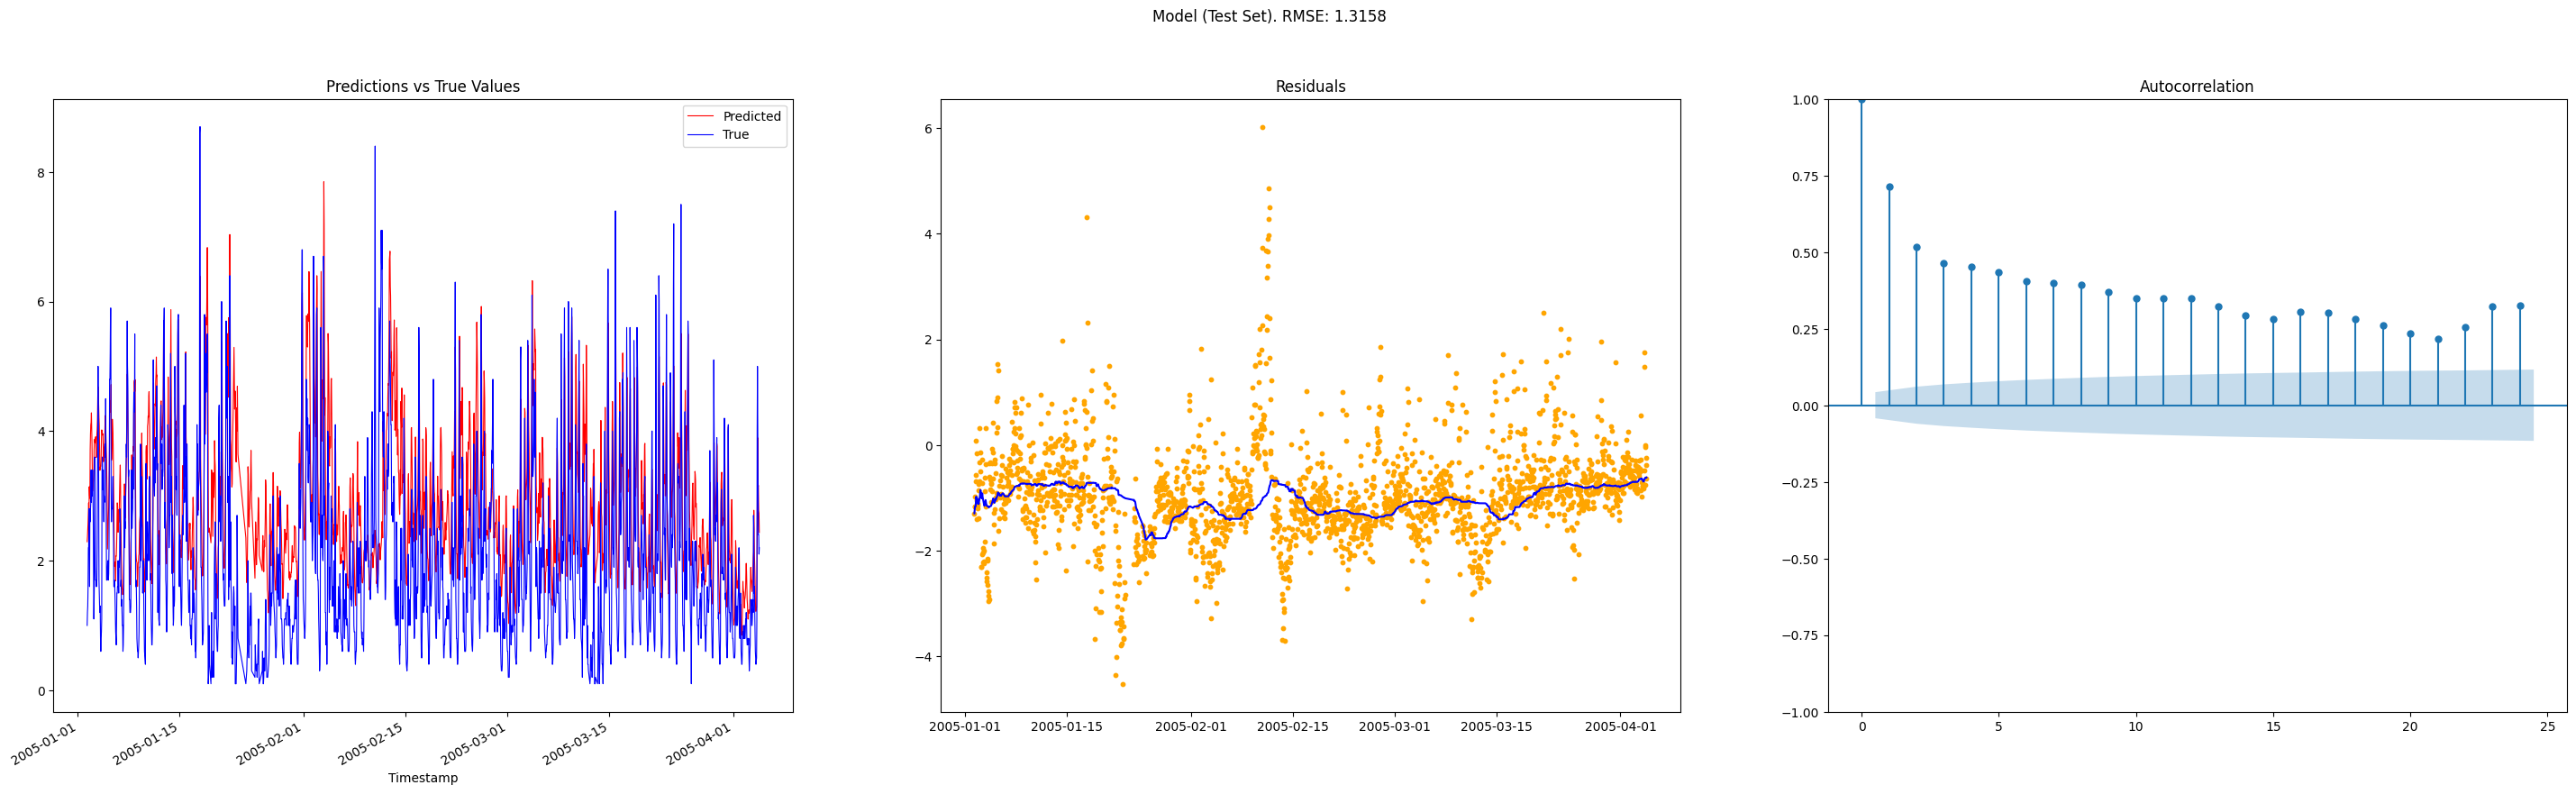

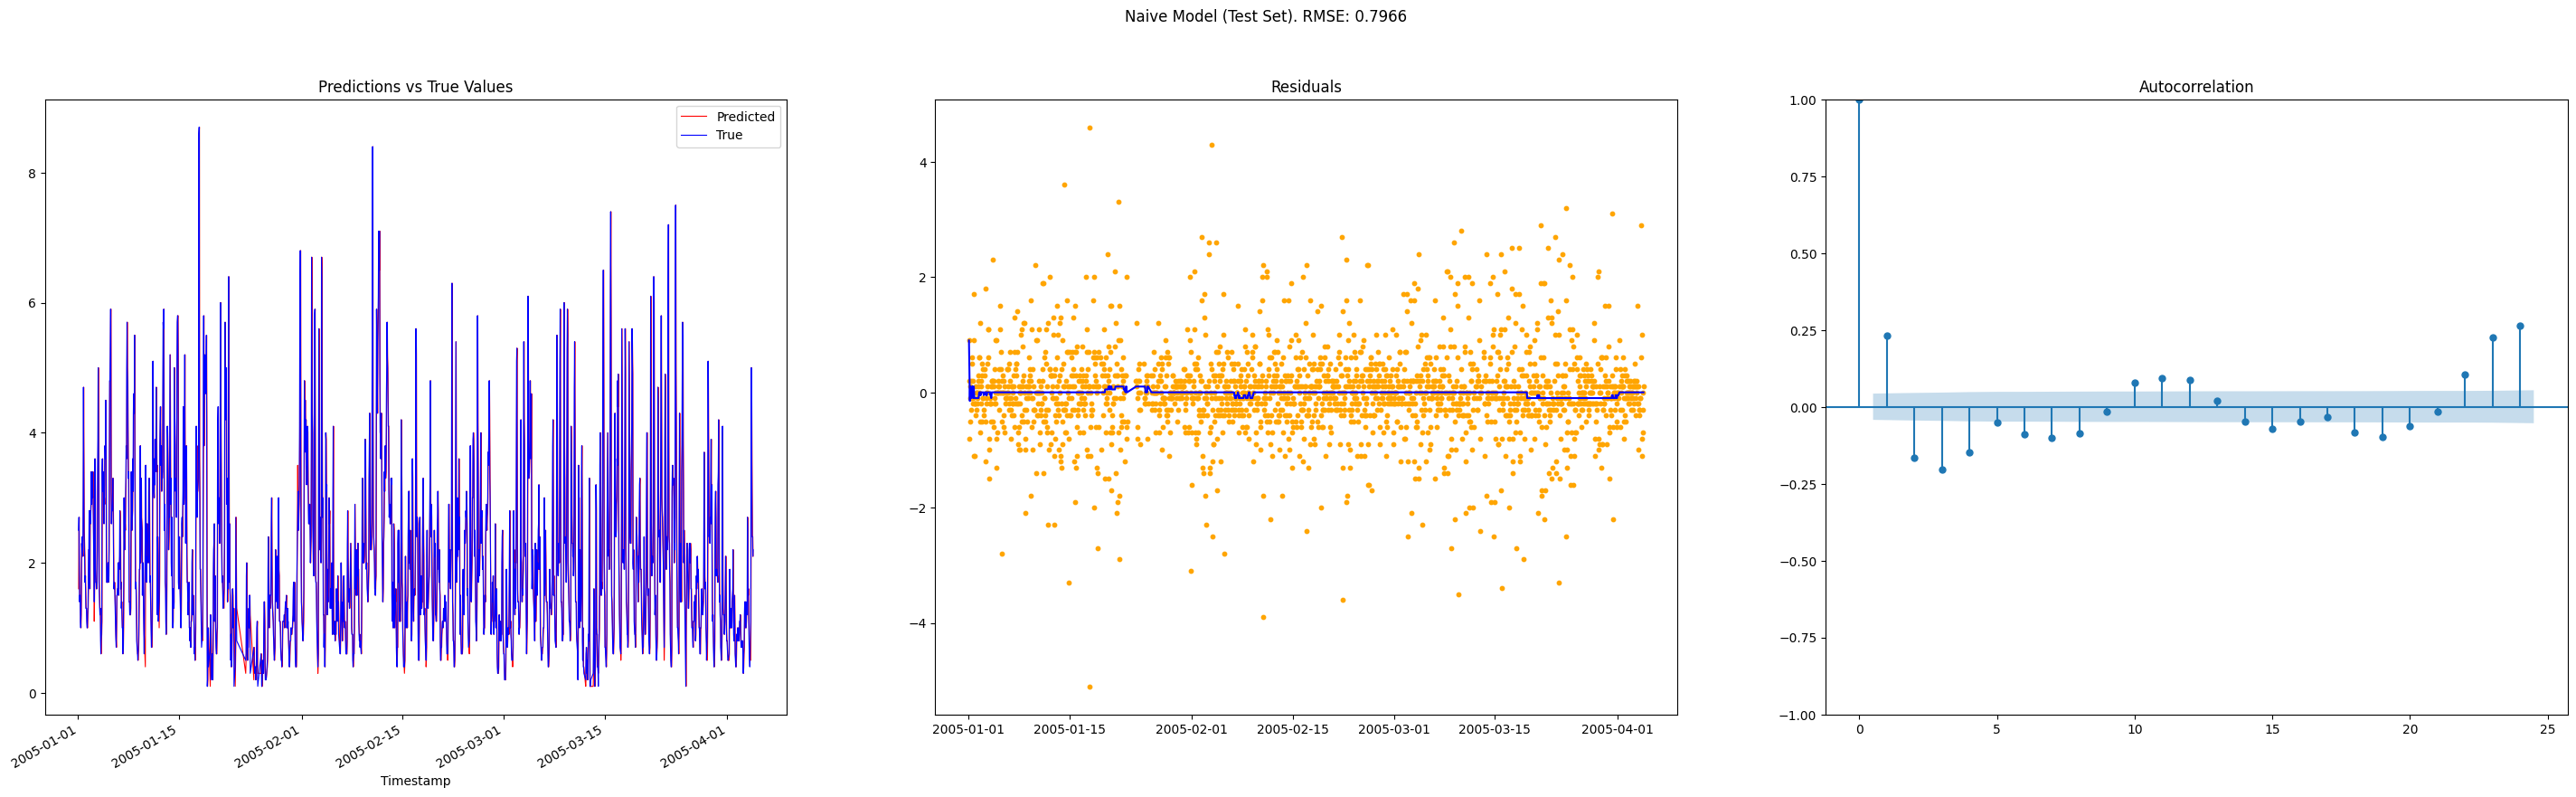

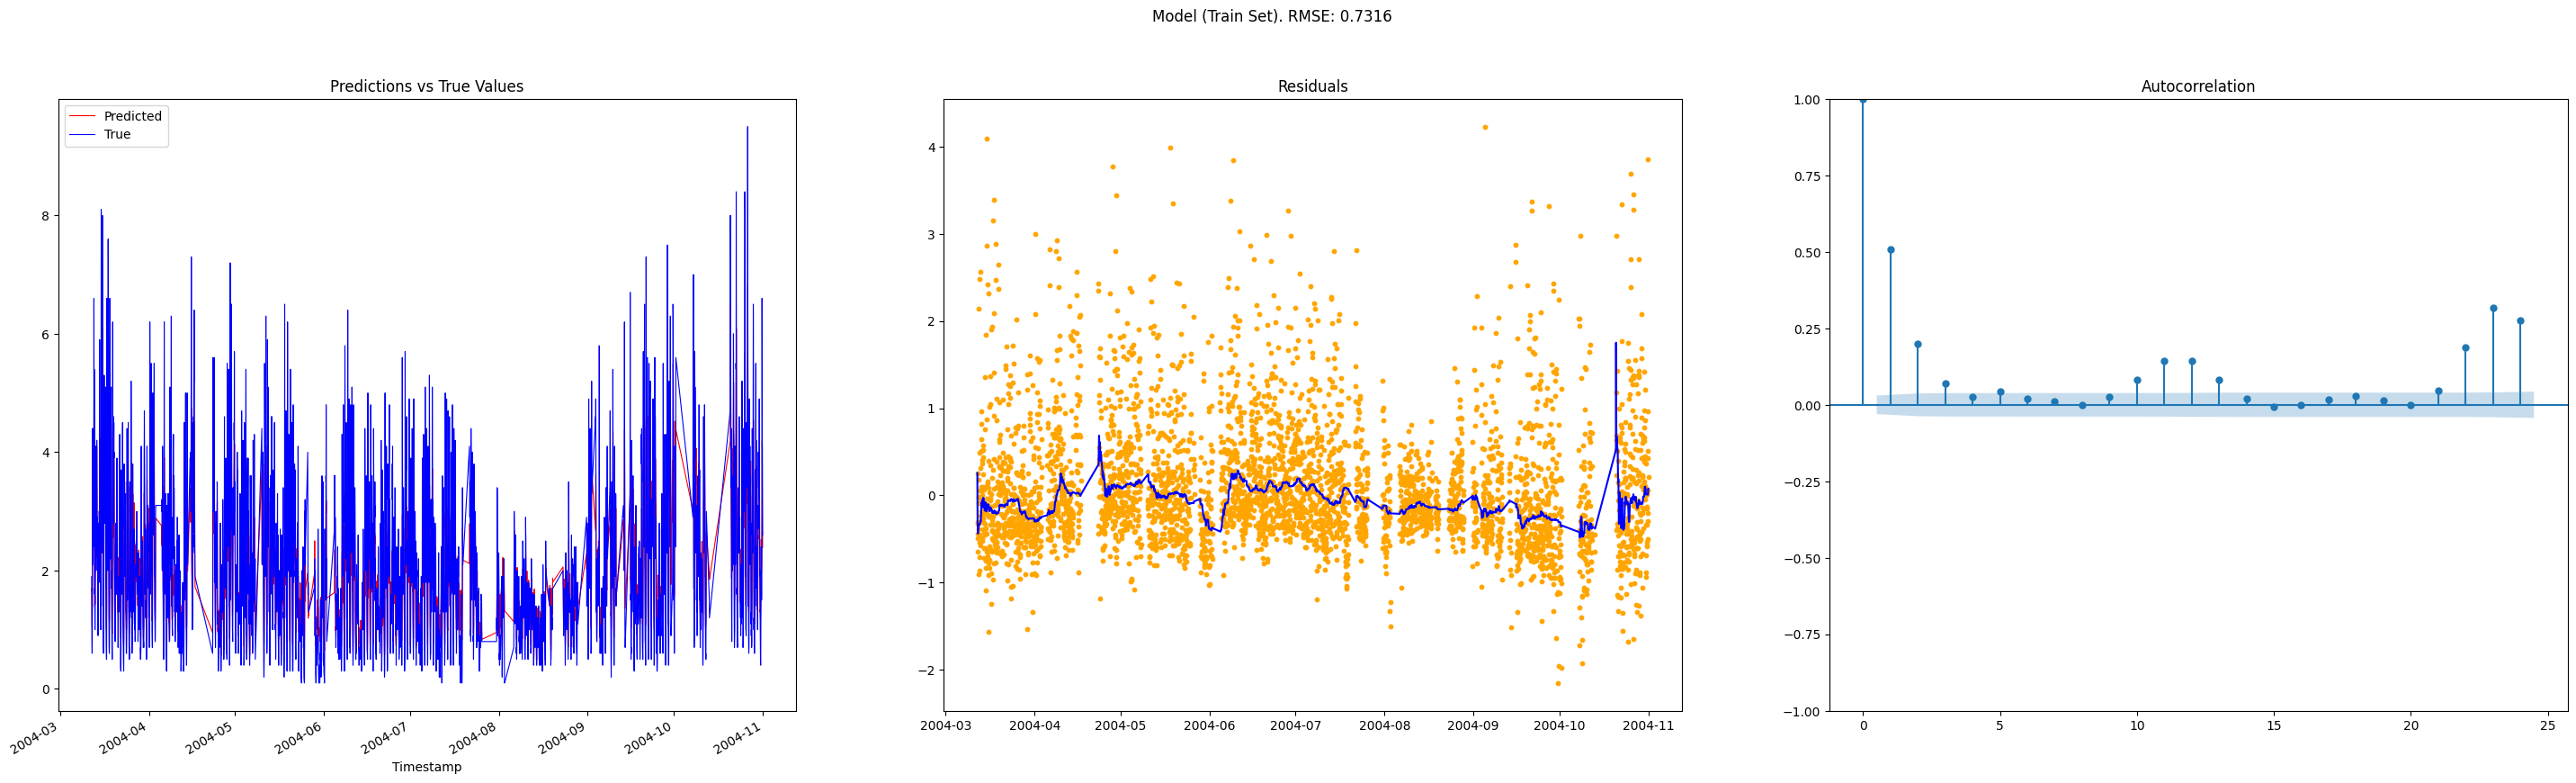

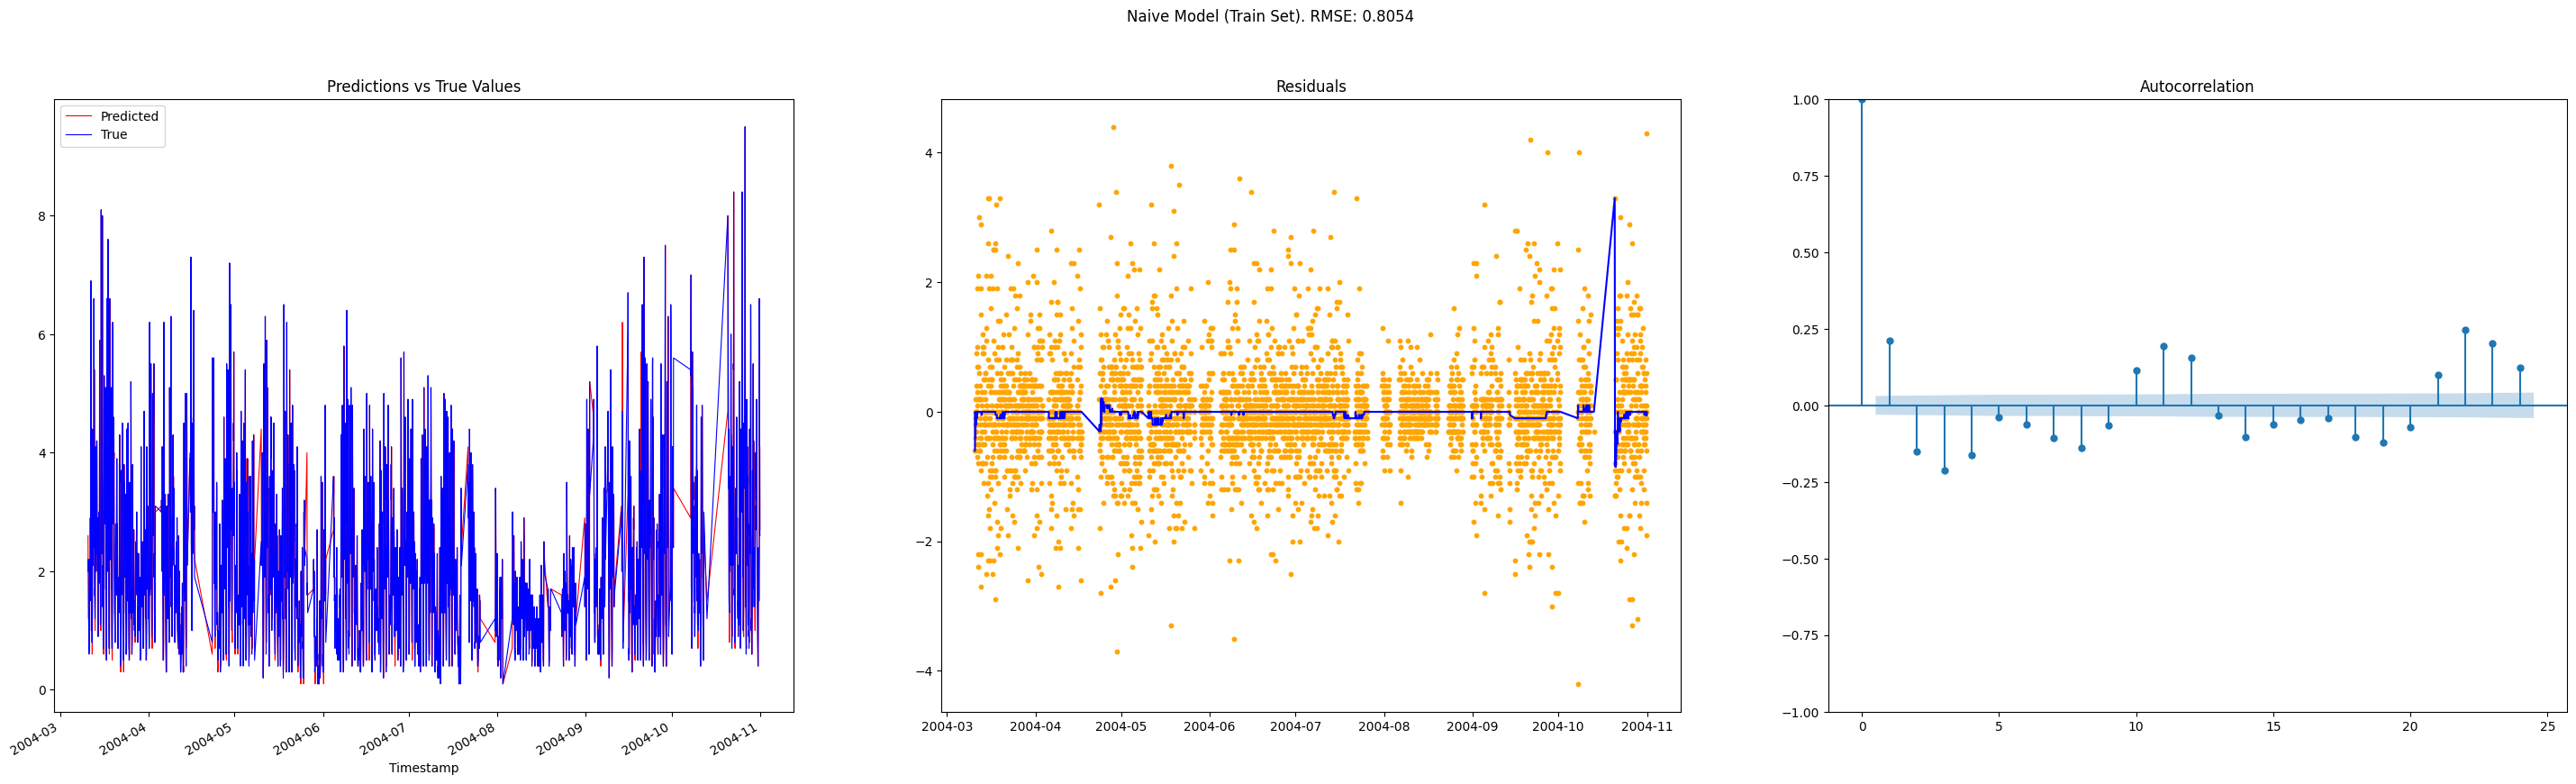

In [124]:
# Comprehensive model evaluation
from statsmodels.graphics.tsaplots import plot_acf 


df_train_y_nona = df_train_y.dropna()[target]
df_val_y_nona = df_val_y.dropna()[target]
df_test_y_nona = df_test_y.dropna()[target]

def evaluation_harness():
    df_train_predict_y = model.predict(df_train_X, transform=True)
    naive_train_predictions = df_train_y.shift(lag).dropna()[target]

    df_predict_y = model.predict(df_test_X, transform=True)
    naive_predictions = df_test_y.shift(lag).dropna()[target]
    
    print(f"Printing model evaluation. Model has hyperparameters {vals}")
    
    evaluate(df_test_y_nona, df_predict_y, 'Model (Test Set)')
    evaluate(df_test_y_nona, naive_predictions, 'Naive Model (Test Set)')
    evaluate(df_train_y_nona, df_train_predict_y, 'Model (Train Set)')
    evaluate(df_train_y_nona, naive_train_predictions, 'Naive Model (Train Set)')

def evaluate(true, predictions, name):
    fig, ax = plt.subplots(1, 3, figsize=(36, 10))

    # normalise indices
    true, predictions = equivalise(true, predictions)
    
    predictions.rename('Predicted')
    true.rename('True')

    line_pred = predictions.plot(linewidth=0.8, color='red', ax=ax[0], label='Predicted')
    line_true = true.plot(linewidth=0.8, color='blue', ax=ax[0], label='True')
    ax[0].set_title(f'Predictions vs True Values')
    ax[0].legend()
    
    residuals = true - predictions
    ax[1].scatter(residuals.index, residuals.values, s=10, color='orange')
    ax[1].set_title(f'Residuals')
    
    roll = residuals.rolling('168h').median()
    ax[1].plot(roll.index, roll.values, color='blue')
    
    rmse = root_mean_squared_error(true.to_numpy(), predictions.to_numpy())
    
    # acf of residuals measures correlation between two residuals - spike at lag 1
    # means that model has undercaptured short term momentum.
    # ideally residuals should just be in the form of noise, so no autocorellation. Low ACF means model extracted all forecastable signal
    plot_acf(residuals, ax=ax[2], lags=24)
    
    fig.suptitle(f'{name}. RMSE: {rmse:.4f}')
    
evaluation_harness()

Index([   0.0,    1.0,    2.0,    3.0,    4.0,    5.0,    6.0,    7.0,    8.0,
          9.0,
       ...
       5636.0, 5637.0, 5638.0, 5639.0, 5640.0, 5641.0, 5642.0, 5643.0, 5644.0,
       5645.0],
      dtype='float64', name='Timestamp', length=5646)